# License Plate Project
Live data stream real-time processing is required, speed and accuracy are the main factors.

# Incoming Truck
<img src="samples/new_truck.jpg"  width="49%" style="float: left; margin: 5px;">
<img src="samples/new_truck_id.png"  width="49%" style="float: left; margin: 5px;">

# Readable License Plate on Truck
<img src="samples/truck.jpg"  width="100%" style="float: left; mergin-bottom: 15px;">

# Process Pipeline
<div style="margin: 10px;">
    <img src="samples/pipeline.png"  width="100%" style="float: left;">
</div>

# Layers
- Truck / Car recognition
- License Plate Detection
- Spatial Transform of License Plate for better Recognition
- License Plate Recognition

In [2]:
# Magical reload for modules
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [34]:
# Video Frames Extractor (First Try One-Threaded)
import OneThreaded
import importlib
importlib.reload(OneThreaded)

export_nth_frame = 300
video_file = "data/video/sample.MP4"
frames_folder = "data/frames"

OneThreaded.extractFrames(pathIn=video_file, pathOut=frames_folder, every=export_nth_frame)

Video frames: 5060
Video fps: 59.94005994005994
Video length (seconds): 84.41766666666666


  0%|          | 0/16 [00:00<?, ?it/s]

16.866666666666667

In [4]:
# Faster Video Frames Extractor for Real-Time Performance (Multi-Threaded)
import MultiThreaded
import importlib
importlib.reload(MultiThreaded)

export_nth_frame = 300
video_file = "data/video/sample.MP4"
frames_folder = "data/frames"
overwrite = False

MultiThreaded.extractFrames(video_path=video_file, frames_dir=frames_folder, overwrite=overwrite, every=export_nth_frame)

Video frames: 5060
Video chunks: 6
Video fps: 59.94005994005994
Video length (seconds): 84.41766666666666


AttributeError: module 'tqdm' has no attribute 'notebook'

In [6]:
# Open Camera and Show Feed (slow fps, picture for picture)

# pip install opencv-python
# pip install matplotlib
import cv2
import matplotlib
import IPython
print("CV2 Version", cv2.__version__)
print("MatPlotLib Version", matplotlib.__version__)
print("IPython Version", IPython.__version__)

def cv2_imshow(cv2image):
    matplotlib.pyplot.imshow(cv2.cvtColor(cv2.flip(cv2image, 1), cv2.COLOR_BGR2RGB))
    matplotlib.pyplot.show()
    
camera = cv2.VideoCapture(0)

try:
    if camera.isOpened():
        ret, frame = camera.read()
        if ret:
            while ret:
                IPython.display.clear_output(wait=True)
                cv2_imshow(frame)
                ret, frame = camera.read()
        else: print("Error: Failed to capture frame!")
    else: print("Error: Failed to open camera!")
except KeyboardInterrupt:
    pass
finally:
    camera.release()
    IPython.display.clear_output()

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [7]:
# Open Camera and Show Feed (better fps)
import cv2
from IPython.display import display, Image

video = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        frame = cv2.flip(frame, 1)
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

In [8]:
# Neuronal Network Layered Stream with the better fps

# pip install opencv-python numpy pillow
import cv2
import IPython
# import PIL.Image

# NN Layer Dummy Grayscale and Flip
def process_frame(frame):
    processed_frame = frame
    processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2GRAY)
    processed_frame = cv2.flip(processed_frame, 1)    
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Couldn't capture frame.")
                break
            processed_frame = process_frame(frame)
            processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            # img = PIL.Image.fromarray(rgb_frame)
            # IPython.display.display(img)
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")

Camera released.


# Yolov8

In [ ]:
pip install ultralytics

In [ ]:
import ultralytics
ultralytics.checks()

In [1]:
from ultralytics import YOLO

In [2]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [3]:
from ultralytics import YOLO
plate_model = YOLO('best_plate_model.pt')

In [4]:
from ultralytics import YOLO
specialist_model = YOLO('best_m_specialist.pt')
# results = specialist_model.train(data='C:\\Users\\Saleh\\Desktop\\BA CV\\LKW Data\\LicensePlateProject\\datasets\\ANPRV4\\data.yaml', epochs=5)

In [88]:
model.info()

Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


(168, 3151904, 0, 8.746444799999999)

In [ ]:
# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data='coco8.yaml', epochs=10)

In [2]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
print(pytesseract.get_languages(config=''))

['eng', 'osd']


# All Objects

In [9]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
from PIL import Image
import pytesseract
import traceback

from ultralytics import YOLO
model = YOLO('yolov8n.pt')

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
            cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.


# Trucks, Cars, Busses

In [3]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
from PIL import Image
import traceback
import math

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

target_classes = ["truck", "bus", "car"]

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
    results = plate_model(processed_frame[y1:y2,x1:x2], agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            # if name2=="License_Plate": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], name2, confidence2)

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
    return processed_frame

def handleFrame(frame):
    processed_frame = process_frame(frame)
    _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    IPython.display.clear_output(wait=True)

def handleRelease():
    cam.release()
    print("Source released.")

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Source released.


# License Plates Detection

In [5]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
from PIL import Image
import traceback

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')
# plate_model = YOLO('best_4.pt')

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = plate_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
            cv2.putText(processed_frame, '{} {:.2f}%'.format(name, confidence*100),(x1+10,y1-15),0,0.9,(255,0,255))
    return processed_frame

def handleFrame(frame):
    processed_frame = process_frame(frame)
    _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    IPython.display.clear_output(wait=True)

def handleRelease():
    cam.release()
    print("Source released.")

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Source released.


# License Plates (PyTesseractOCR)

In [7]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
from PIL import Image
import numpy as np
import pytesseract
import traceback

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    gray = cv2.cvtColor(np.array(processed_frame[y1:y2,x1:x2]), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plate_text = pytesseract.image_to_string(thresh, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    cv2.putText(processed_frame, '{} {:.2f}%'.format(plate_text, confidence*100),(x1+10,y1-15),0,0.9,(255,0,255),3)

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = plate_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            # cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
            # cv2.putText(processed_frame, '{} {:.2f}%'.format(plate_text, confidence*100),(x1+10,y1-15),0,0.9,(255,0,255))
            process_license(processed_frame, bounding_box, name, confidence)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.


# License Plates (EasyOCR)

In [13]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
from PIL import Image
import easyocr
import traceback

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

reader = easyocr.Reader(['de'])

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    gray = cv2.cvtColor(processed_frame[y1:y2,x1:x2] , cv2.COLOR_RGB2GRAY)
    #gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    result = reader.readtext(gray)
    text = ""
    for res in result:
        if len(result) == 1:
            text = res[1]
        if len(result) >1 and len(res[1])>6 and res[2]> 0.2:
            text = res[1]
    #     text += res[1] + " "
    cv2.putText(processed_frame, '{} {:.2f}%'.format(str(text), confidence*100),(x1+10,y1-15),0,0.9,(255,0,255),3)

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = plate_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            # cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
            # cv2.putText(processed_frame, '{} {:.2f}%'.format(name, confidence*100),(x1+10,y1-15),0,0.9,(255,0,255))
            process_license(processed_frame, bounding_box, name, confidence)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.


# All together

In [14]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from PIL import Image
import pytesseract
import traceback

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    gray = cv2.cvtColor(np.array(processed_frame[y1:y2,x1:x2]), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plate_text = pytesseract.image_to_string(thresh, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    cv2.putText(processed_frame, '{} {:.2f}%'.format(plate_text, confidence*100),(x1+10,y1-15),0,0.9,(255,0,255),3)

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
    results = plate_model(processed_frame[y1:y2,x1:x2], agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            if name2=="License_Plate": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], name2, confidence2)

# NN Layer Other Objects Detected
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.


# EasyOCR

In [58]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from PIL import Image
import traceback
import easyocr

reader = easyocr.Reader(['de'])

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

target_classes = ["truck", "bus", "car"]

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    gray = cv2.cvtColor(np.array(processed_frame[y1:y2,x1:x2]), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    result = reader.readtext(thresh)
    text = ""
    conf = 0.0
    for res in result:
        if res[2]>conf:
            conf=res[2]
            text=res[1]
    cv2.putText(processed_frame, '{} {:.2f}%'.format(str(text), conf*100),(x1+10,y1-15),0,0.9,(255,0,255),3)

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
    results = plate_model(processed_frame[y1:y2,x1:x2], agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            if name2=="licence": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], "license", confidence2)

# NN Layer Other Objects Detected
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.


# Specialist Model

In [15]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from PIL import Image
import pytesseract
import traceback
import re

from ultralytics import YOLO
specialist_model = YOLO('best_m_specialist.pt') # Self trained yolov8m on ANPRv4 Dataset

detected_plates = []

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName='test', parentConfidence=0.0):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,0,255))

    license_frame = processed_frame[y1:y2,x1:x2]
    grayscaled = get_grayscale(np.array(license_frame))
    threshholded = thresholding(grayscaled)
    # angle = determine_skew(threshholded)
    # print(angle)
    # threshholded = rotate(threshholded, angle, (0, 0, 0))

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    max_conf = 0.0
    best_text = ""
    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text])
    cv2.putText(processed_frame, '{} {:.2f}%'.format(best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = specialist_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
            cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
            if name=="license-plate": process_license(processed_frame, bounding_box, name, confidence) 
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
        correct_plates = []
        best_plates = []
        most_repeated_plates = []
        best_repeated_plates = []
        if len(detected_plates)>0:
            repetitions = {}
            count, item = 0, ''  
            for plate in detected_plates:
                if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
                if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: best_plates.append(plate)
                repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
                if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
            if len(repetitions.keys())>0:
                for itm in repetitions.keys():
                    if repetitions[itm]==count:
                        repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                        best_percentages = []
                        for plate in repeated_detected: 
                            if len(best_percentages)==0: best_percentages=plate
                            elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                        most_repeated_plates.append(best_percentages)
            if len(most_repeated_plates)>0:
                for plate in most_repeated_plates:
                    best_repeated = []
                    if len(best_repeated)==0: best_repeated=plate 
                    elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
                best_repeated_plates.append(best_repeated)

        print("\nDetected Plates: \n", np.matrix(detected_plates))
        print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
        print("\nBest Detected Plates: \n", np.matrix(best_plates))
        print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
        print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.

Detected Plates: 
 [['0.0' 'TEST' '61.771780252456665' 'LICENSE-PLATE' '39.587051' '7']
 ['0.0' 'TEST' '25.346070528030396' 'LICENSE-PLATE' '4.13456' '7']
 ['0.0' 'TEST' '25.346070528030396' 'LICENSE-PLATE' '25.67012' '4']
 ['0.0' 'TEST' '55.83570599555969' 'LICENSE-PLATE' '20.816376' 'OE']
 ['0.0' 'TEST' '59.33477282524109' 'LICENSE-PLATE' '28.768173' '3S']
 ['0.0' 'TEST' '28.437989950180054' 'LICENSE-PLATE' '4.298164' 'TT']]

Correctly Detected Plates: 
 []

Best Detected Plates: 
 []

Most Repeated Plates: 
 [['0.0' 'TEST' '61.771780252456665' 'LICENSE-PLATE' '39.587051' '7']]

Best Repeated Plate: 
 [['0.0' 'TEST' '61.771780252456665' 'LICENSE-PLATE' '39.587051' '7']]


# Optimized Specialist Model

In [57]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from PIL import Image
import pytesseract
import traceback
import re

from ultralytics import YOLO
specialist_model = YOLO('best_m_specialist.pt') # Self trained yolov8m on ANPRv4 Dataset

detected_plates = []

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,0,255))

    license_frame = processed_frame[y1:y2,x1:x2]
    grayscaled = get_grayscale(np.array(license_frame))
    threshholded = thresholding(grayscaled)

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    max_conf = 0.0
    best_text = ""
    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text])
    cv2.putText(processed_frame, '{} {:.2f}%'.format(best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = specialist_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            
            if name=="license-plate":
                for j in range(detection_count):
                    parentCls = int(result.boxes.cls[j].item())
                    parentName = result.names[parentCls]
                    parentConfidence = float(result.boxes.conf[j].item())
                    parent_bounding_box = result.boxes.xyxy[j].cpu().numpy()
                    px1, py1, px2, py2 = [int(x) for x in parent_bounding_box]
                    px1, px2 = min(px1, px2), max(px1, px2)
                    py1, py2 = min(py1, py2), max(py1, py2)
                    
                    if parentName!="license-plate": continue

                    if px1<=x1 and x2<=px2 and py1<=y1 and y2<=py2:
                        cv2.rectangle(processed_frame,(px1,py1),(px2,py2),(0,255,255),2)
                        cv2.putText(processed_frame, '{} {:.2f}%'.format(parentName.upper(), parentConfidence*100),(px1+10,py1-15),0,0.7,(0,255,255))
                        process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence) 
            else:
                cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
                cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
    
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
        correct_plates = []
        better_plates = []
        best_plate = []
        most_repeated_plates = []
        best_repeated_plates = []
        highest_score = 0.0
        if len(detected_plates)>0:
            repetitions = {}
            count, item = 0, ''  
            for plate in detected_plates:
                if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
                if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: better_plates.append(plate)
                if plate[0] + plate[2] + plate[4] > highest_score:
                    highest_score = plate[0] + plate[2] + plate[4]
                    best_plate = plate
                repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
                if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
            if len(repetitions.keys())>0:
                for itm in repetitions.keys():
                    if repetitions[itm]==count:
                        repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                        best_percentages = []
                        for plate in repeated_detected: 
                            if len(best_percentages)==0: best_percentages=plate
                            elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                        most_repeated_plates.append(best_percentages)
            if len(most_repeated_plates)>0:
                for plate in most_repeated_plates:
                    best_repeated = []
                    if len(best_repeated)==0: best_repeated=plate 
                    elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
                best_repeated_plates.append(best_repeated)

        print("\nDetected Plates: \n", np.matrix(detected_plates))
        print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
        print("\nBetter Detected Plates: \n", np.matrix(better_plates))
        print("\nBest Detected Plate: \n", np.matrix(best_plate))
        print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
        print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.

Detected Plates: 
 [['57.76347517967224' 'LICENSE-PLATE' '57.76347517967224' 'LICENSE-PLATE' '77.33049' '4']
 ['44.09739673137665' 'LICENSE-PLATE' '44.09739673137665' 'LICENSE-PLATE' '24.931633' 'EE']
 ['75.11534690856934' 'LICENSE-PLATE' '75.11534690856934' 'LICENSE-PLATE' '14.808159' 'EK2Z3S07']
 ['74.15632605552673' 'LICENSE-PLATE' '74.15632605552673' 'LICENSE-PLATE' '29.706108' 'EKZ954T']
 ['74.14078116416931' 'LICENSE-PLATE' '74.14078116416931' 'LICENSE-PLATE' '10.870621' 'EK23SVT']
 ['76.28211379051208' 'LICENSE-PLATE' '76.28211379051208' 'LICENSE-PLATE' '61.949154' 'EK23SVT']
 ['25.527092814445496' 'LICENSE-PLATE' '25.527092814445496' 'LICENSE-PLATE' '11.560822' '0']
 ['25.527092814445496' 'LICENSE-PLATE' '25.527092814445496' 'LICENSE-PLATE' '20.487007' 'TR']]

Correctly Detected Plates: 
 [['57.76347517967224' 'LICENSE-PLATE' '57.76347517967224' 'LICENSE-PLATE' '77.33049' '4']
 ['76.28211379051208' 'LICENSE-PLATE' '76.28211379051208' 'LICENSE-PLATE' '61.949154

# All together (Parallel)

In [16]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from PIL import Image
import pytesseract
import traceback

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    gray = cv2.cvtColor(np.array(processed_frame[y1:y2,x1:x2]), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plate_text = pytesseract.image_to_string(thresh, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    cv2.putText(processed_frame, '{} {:.2f}%'.format(plate_text, confidence*100),(x1+10,y1-15),0,0.9,(255,0,255),3)

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))

# NN Layer Other Objects Detected
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    resultss = plate_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in resultss:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name2=="License_Plate": process_license(processed_frame, bounding_box2, name2, confidence2)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
        
        correct_plates = []
        better_plates = []
        best_plate = []
        most_repeated_plates = []
        best_repeated_plates = []
        highest_score = 0.0
        if len(detected_plates)>0:
            repetitions = {}
            count, item = 0, ''  
            for plate in detected_plates:
                if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
                if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: better_plates.append(plate)
                if plate[0] + plate[2] + plate[4] > highest_score:
                    highest_score = plate[0] + plate[2] + plate[4]
                    best_plate = plate
                repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
                if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
            if len(repetitions.keys())>0:
                for itm in repetitions.keys():
                    if repetitions[itm]==count:
                        repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                        best_percentages = []
                        for plate in repeated_detected: 
                            if len(best_percentages)==0: best_percentages=plate
                            elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                        most_repeated_plates.append(best_percentages)
            if len(most_repeated_plates)>0:
                for plate in most_repeated_plates:
                    best_repeated = []
                    if len(best_repeated)==0: best_repeated=plate 
                    elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
                best_repeated_plates.append(best_repeated)

        print("\nDetected Plates: \n", np.matrix(detected_plates))
        print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
        print("\nBetter Detected Plates: \n", np.matrix(better_plates))
        print("\nBest Detected Plate: \n", np.matrix(best_plate))
        print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
        print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.

Detected Plates: 
 [['0.0' 'TEST' '61.771780252456665' 'LICENSE-PLATE' '39.587051' '7']
 ['0.0' 'TEST' '25.346070528030396' 'LICENSE-PLATE' '4.13456' '7']
 ['0.0' 'TEST' '25.346070528030396' 'LICENSE-PLATE' '25.67012' '4']
 ['0.0' 'TEST' '55.83570599555969' 'LICENSE-PLATE' '20.816376' 'OE']
 ['0.0' 'TEST' '59.33477282524109' 'LICENSE-PLATE' '28.768173' '3S']
 ['0.0' 'TEST' '28.437989950180054' 'LICENSE-PLATE' '4.298164' 'TT']]

Correctly Detected Plates: 
 []

Better Detected Plates: 
 []

Best Detected Plate: 
 [['0.0' 'TEST' '61.771780252456665' 'LICENSE-PLATE' '39.587051' '7']]

Most Repeated Plates: 
 [['0.0' 'TEST' '61.771780252456665' 'LICENSE-PLATE' '39.587051' '7']]

Best Repeated Plate: 
 [['0.0' 'TEST' '61.771780252456665' 'LICENSE-PLATE' '39.587051' '7']]


# All together optimized parallel with tracking

In [14]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from PIL import Image
import pytesseract
import traceback

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

detected_plates = []

# NN Layer License Plate Recognition "Dummy OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    color = (255,0,255)
    if parentName!="vehicle": color = (0,255,0)
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),color,2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.9,color,3)
    gray = cv2.cvtColor(np.array(processed_frame[y1:y2,x1:x2]), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plate_text = pytesseract.image_to_string(thresh, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    max_conf = 0.0
    best_text = ""
    parsedLines = plate_text.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text])
    cv2.putText(processed_frame, '{} {:.2f}%'.format(best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)

# NN Layer Vehicle Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))

# NN Layer Other Objects Detected
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    # results = model.track(processed_frame, agnostic_nms=True, verbose=False, persist=True)[0]
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            # track_id = result.boxes.id.int().cpu().tolist()
            name = result.names[cls] # +" "+str(track_id[0])
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    resultss = plate_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in resultss:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            
            name = "vehicle"
            confidence = 0.0
            for result in results:
                detection_count = result.boxes.shape[0]
                for i in range(detection_count):
                    cls = int(result.boxes.cls[i].item())
                    vname = result.names[cls]
                    vconfidence = float(result.boxes.conf[i].item())
                    bounding_box = result.boxes.xyxy[i].cpu().numpy()
                    # track_id = result.boxes.id.int().cpu().tolist()
                    if name in target_classes: 
                        vx1, vy1, vx2, vy2 = [int(x) for x in bounding_box2]
                        # Ensure a1 < a2 and b1 < b2
                        vx1, vx2 = min(vx1, vx2), max(vx1, vx2)
                        vy1, vy2 = min(vy1, vy2), max(vy1, vy2)
                        if vx1<=x1 and x2<=vx2 and vy1<=y1 and y2<=vy2:
                            name=vname # +" "+str(track_id[0])
                            confidence=vconfidence
            
            if name2=="License_Plate": process_license(processed_frame, bounding_box2, name2, confidence2, name, confidence)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
        
        correct_plates = []
        better_plates = []
        best_plate = []
        most_repeated_plates = []
        best_repeated_plates = []
        highest_score = 0.0
        if len(detected_plates)>0:
            repetitions = {}
            count, item = 0, ''  
            for plate in detected_plates:
                if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
                if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: better_plates.append(plate)
                if plate[0] + plate[2] + plate[4] > highest_score:
                    highest_score = plate[0] + plate[2] + plate[4]
                    best_plate = plate
                repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
                if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
            if len(repetitions.keys())>0:
                for itm in repetitions.keys():
                    if repetitions[itm]==count:
                        repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                        best_percentages = []
                        for plate in repeated_detected: 
                            if len(best_percentages)==0: best_percentages=plate
                            elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                        most_repeated_plates.append(best_percentages)
            if len(most_repeated_plates)>0:
                for plate in most_repeated_plates:
                    best_repeated = []
                    if len(best_repeated)==0: best_repeated=plate 
                    elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
                best_repeated_plates.append(best_repeated)

        print("\nDetected Plates: \n", np.matrix(detected_plates))
        print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
        print("\nBetter Detected Plates: \n", np.matrix(better_plates))
        print("\nBest Detected Plate: \n", np.matrix(best_plate))
        print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
        print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.

Detected Plates: 
 []

Correctly Detected Plates: 
 []

Better Detected Plates: 
 []

Best Detected Plate: 
 []

Most Repeated Plates: 
 []

Best Repeated Plate: 
 []


In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AttnLabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character):
        # character (str): set of the possible characters.
        # [GO] for the start token of the attention decoder. [s] for end-of-sentence token.
        list_token = ['[GO]', '[s]']  # ['[s]','[UNK]','[PAD]','[GO]']
        list_character = list(character)
        self.character = list_token + list_character

        self.dict = {}
        for i, char in enumerate(self.character):
            # print(i, char)
            self.dict[char] = i

    def encode(self, text, batch_max_length=25):
        """ convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]
            batch_max_length: max length of text label in the batch. 25 by default

        output:
            text : the input of attention decoder. [batch_size x (max_length+2)] +1 for [GO] token and +1 for [s] token.
                text[:, 0] is [GO] token and text is padded with [GO] token after [s] token.
            length : the length of output of attention decoder, which count [s] token also. [3, 7, ....] [batch_size]
        """
        length = [len(s) + 1 for s in text]  # +1 for [s] at end of sentence.
        # batch_max_length = max(length) # this is not allowed for multi-gpu setting
        batch_max_length += 1
        # additional +1 for [GO] at first step. batch_text is padded with [GO] token after [s] token.
        batch_text = torch.LongTensor(len(text), batch_max_length + 1).fill_(0)
        for i, t in enumerate(text):
            text = list(t)
            text.append('[s]')
            text = [self.dict[char] for char in text]
            batch_text[i][1:1 + len(text)] = torch.LongTensor(text)  # batch_text[:, 0] = [GO] token
        return (batch_text.to(device), torch.IntTensor(length).to(device))

    def decode(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        for index, l in enumerate(length):
            text = ''.join([self.character[i] for i in text_index[index, :]])
            texts.append(text)
        return texts


class Averager(object):
    """Compute average for torch.Tensor, used for loss average."""

    def __init__(self):
        self.reset()

    def add(self, v):
        count = v.data.numel()
        v = v.data.sum()
        self.n_count += count
        self.sum += v

    def reset(self):
        self.n_count = 0
        self.sum = 0

    def val(self):
        res = 0
        if self.n_count != 0:
            res = self.sum / float(self.n_count)
        return res


In [8]:
import torch.nn as nn

from modules.transformation import TPS_SpatialTransformerNetwork
from modules.feature_extraction import VGG_FeatureExtractor, RCNN_FeatureExtractor, ResNet_FeatureExtractor
from modules.sequence_modeling import BidirectionalLSTM
from modules.prediction import Attention

class Model(nn.Module):

    def __init__(self, num_class):
        super(Model, self).__init__()
        self.stages = {'Trans': "TPS", 'Feat': "ResNet", 'Seq': "BiLSTM", 'Pred': "Attn"}

        """ Transformation """
        self.Transformation = TPS_SpatialTransformerNetwork(F=20, I_size=(32, 100), I_r_size=(32, 100), I_channel_num=1)

        """ FeatureExtraction """
        self.FeatureExtraction = ResNet_FeatureExtractor(1, 512)
        self.FeatureExtraction_output = 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))

        """ Sequence modeling"""
        self.SequenceModeling = nn.Sequential(BidirectionalLSTM(self.FeatureExtraction_output, 256, 256),BidirectionalLSTM(256, 256, 256))
        self.SequenceModeling_output = 256

        """ Prediction """
        self.Prediction = Attention(self.SequenceModeling_output, 256, num_class)

    def forward(self, input, text, is_train=True):
        """ Transformation stage """
        if not self.stages['Trans'] == "None":
            input = self.Transformation(input)

        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        if self.stages['Seq'] == 'BiLSTM':
            contextual_feature = self.SequenceModeling(visual_feature)
        else:
            contextual_feature = visual_feature  # for convenience. this is NOT contextually modeled by BiLSTM

        """ Prediction stage """
        prediction = self.Prediction(contextual_feature.contiguous(), text, False, batch_max_length=25)

        return prediction


# Best YoloV8

In [19]:
import cv2
import IPython
import numpy as np
from typing import Tuple, Union
import math
from PIL import Image
import pytesseract
import traceback
import re
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.transforms as transforms 

from deskew import determine_skew

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import sys
# sys.path.append('./LPRNet')
# sys.path.append('./MTCNN')
# # from LPRNet_Test import *
# from MTCNN import *

import easyocr
reader = easyocr.Reader(['de'])

from ultralytics import YOLO
yolo_model = YOLO('yolov8m.pt')
# plate_model = YOLO('best_plate_model.pt')
plate_model = YOLO('best_3.pt')

detected_plates = []

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ" # '0123456789abcdefghijklmnopqrstuvwxyz' # "0123456789ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ"

converter = AttnLabelConverter(characters)
num_class = len(converter.character)

model = Model(num_class)
model = torch.nn.DataParallel(model).to(device)
model.load_state_dict(torch.load("TPS-ResNet-BiLSTM-Attn.pth", map_location=device))
model.eval()

# STN = STNet()
# STN.to(device)
# STN.load_state_dict(torch.load('LPRNet/weights/Final_STN_model.pth', map_location=lambda storage, loc: storage))
# STN.eval()

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def compute_skew(src_img):
    if len(src_img.shape) == 3:
        h, w, _ = src_img.shape
    elif len(src_img.shape) == 2:
        h, w = src_img.shape
    else:
        print('upsupported image type')
    img = cv2.medianBlur(src_img, 3)
    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 4.0, maxLineGap=h/4.0)
    angle = 0.0
    nlines = lines.size
    #print(nlines)
    cnt = 0
    for x1, y1, x2, y2 in lines[0]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        #print(ang)
        if math.fabs(ang) <= 30: # excluding extreme rotations
            angle += ang
            cnt += 1
    if cnt == 0:
        return 0.0
    return (angle / cnt)*180/math.pi

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def get_deskew_angle(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle<-45: angle=-angle
    return angle

def deskew_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

# NN Layer License Plate Recognition "OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.9,(255,0,255),2)

    # Rotation
    # license_frame = deskew(processed_frame[y1:y2,x1:x2])
    license_frame = processed_frame[y1:y2,x1:x2]
    
    # pframe = cv2.resize(license_frame, (94, 24), interpolation=cv2.INTER_CUBIC)
    # pframe = (np.transpose(np.float32(pframe), (2, 0, 1)) - 127.5)*0.0078125
    # pframe = torch.from_numpy(pframe).float().unsqueeze(0).to("cpu")
    # pframe = STN(pframe)
    # spatial_transformed = convert_image(pframe)
    # plt.imshow(spatial_transformed[:,:,::-1])
    # plt.show()
    
    grayscaled = get_grayscale(license_frame) # get_grayscale(np.array(license_frame))
    # angle = determine_skew(grayscaled)
    threshholded = thresholding(grayscaled) # deskew_image(thresholding(grayscaled), angle)
    
    # newdata=pytesseract.image_to_osd(threshholded)
    # angle=float(re.search('(?<=Rotate: )\d+', newdata).group(0))
    # print('osd angle:',angle)
    
    # angle = compute_skew(thresholding(grayscaled))
    # threshholded = rotate_image(thresholding(grayscaled), angle)
    # dilated = dilate(threshholded)
    # plt.imshow(deskew(threshholded))
    
    # print(angle)
    # plt.imshow(threshholded)
    # plt.show()
    
    max_conf = 0.0
    best_text = ""

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    # NN Layer License Plate Recognition "Dummy OCR"

    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text, "pytesseract"])
    cv2.putText(processed_frame, '{} {:.2f}%'.format("[tesse]: "+best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)
    
    result = reader.readtext(threshholded)
    text = ""
    conf = 0.0
    for res in result:
        if res[2]>conf:
            conf=res[2]
            text=res[1]
            if res[2]*100>max_conf:
                max_conf = res[2]*100
                best_text = res[1]
                if max_conf>0.0 and len(best_text)>0: 
                    detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text, "easyocr"])
    cv2.putText(processed_frame, '{} {:.2f}%'.format("[easy]: "+str(text), conf*100),(x1+10,y2+57),0,0.9,(200,200,200),3)
    
    transform = Image.fromarray(threshholded).resize((32, 100), Image.BICUBIC)
    transform = transforms.ToTensor()(transform)
    transform = transform.sub_(0.5).div_(0.5)
    image_tensors = [image for image in [transform]]
    image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)
    
    with torch.no_grad():
        batch_size = image_tensors.size(0)
        image = image_tensors.to(device)
        length_for_pred = torch.IntTensor([25] * batch_size).to(device)
        text_for_pred = torch.LongTensor(batch_size, 25 + 1).fill_(0).to(device)

        preds = model(image, text_for_pred, is_train=False)

        _, preds_index = preds.max(2)
        preds_str = converter.decode(preds_index, length_for_pred)
        preds_prob = F.softmax(preds, dim=2)
        preds_max_prob, _ = preds_prob.max(dim=2)
        for pred, pred_max_prob in zip(preds_str, preds_max_prob):
            pred_EOS = pred.find('[s]')
            pred = pred[:pred_EOS]  # prune after "end of sentence" token ([s])
            pred_max_prob = pred_max_prob[:pred_EOS]
            confidence_score = pred_max_prob.cumprod(dim=0)[-1]
            if confidence_score*100>max_conf:
                    max_conf = confidence_score*100
                    best_text = pred
                    if max_conf>0.0 and len(best_text)>0: 
                        detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text, "resnet"])
            cv2.putText(processed_frame, '{} {:.2f}%'.format("[resnet]: "+str(pred), confidence_score*100),(x1+10,y2+90),0,0.9,(255,255,255),3)

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    
    # Yolov8n Bounding Boxes
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1+25),0,0.8,(0,255,255),2)
    vehicle_frame = processed_frame[y1:y2,x1:x2]
    results = plate_model(vehicle_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            # if name2=="License_Plate": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], name2, confidence2, name, confidence)
            process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], name2, confidence2, name, confidence)

# NN Layer Other Objects Detected [Not target classes]
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1+25),0,0.8,(255,255,0),2)
    
# NN Layer Yolov8 Detection
def yolov8n_objects(frame):
    processed_frame = frame
    start_time = time.time()
    results = yolo_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    end_time = time.time()
    processing_time = end_time - start_time
    # print(f"Processing time yolov8: {processing_time:.3f} seconds")  # Output processing time
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    return processed_frame

def process_frame(frame):
    processed_frame = yolov8n_objects(frame)
    # processed_frame = cv2.flip(processed_frame, 1)
    return processed_frame

def handleFrame(frame):
    processed_frame = process_frame(frame)
    _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    IPython.display.clear_output(wait=True)
    
def handleRelease():
    cam.release()
    print("Source released.")
    correct_plates = []
    better_plates = []
    best_plate = []
    most_repeated_plates = []
    best_repeated_plates = []
    highest_score = 0.0
    if len(detected_plates)>0:
        repetitions = {}
        count, item = 0, ''  
        for plate in detected_plates:
            if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
            if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: better_plates.append(plate)
            if plate[0] + plate[2] + plate[4] > highest_score:
                highest_score = plate[0] + plate[2] + plate[4]
                best_plate = plate
            repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
            if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
        if len(repetitions.keys())>0:
            for itm in repetitions.keys():
                if repetitions[itm]==count:
                    repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                    best_percentages = []
                    for plate in repeated_detected: 
                        if len(best_percentages)==0: best_percentages=plate
                        elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                    most_repeated_plates.append(best_percentages)
        if len(most_repeated_plates)>0:
            for plate in most_repeated_plates:
                best_repeated = []
                if len(best_repeated)==0: best_repeated=plate 
                elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
            best_repeated_plates.append(best_repeated)
    print("\nDetected Plates: \n", np.matrix(detected_plates))
    print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
    print("\nBetter Detected Plates: \n", np.matrix(better_plates))
    print("\nBest Detected Plate: \n", np.matrix(best_plate))
    print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
    print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Source released.

Detected Plates: 
 [['65.81149101257324' 'BUS' '84.66718792915344' 'LICENSE-PLATE' '28.131838772282723' 'hh379' 'easyocr']
 ['65.81149101257324' 'BUS' '84.66718792915344' 'LICENSE-PLATE' '44.030395856556865' 'MAF' 'easyocr']
 ['62.92336583137512' 'TRUCK' '86.51658296585083' 'LICENSE-PLATE' '9.921188229131554' 'MF4lE7)' 'easyocr']
 ['82.50477910041809' 'BUS' '85.72361469268799' 'LICENSE-PLATE' '10.167027241506576' 'HFsHkB7)' 'easyocr']
 ['82.50477910041809' 'BUS' '85.72361469268799' 'LICENSE-PLATE' 'tensor(15.8874)' 'THE' 'resnet']
 ['81.39787912368774' 'BUS' '85.22861003875732' 'LICENSE-PLATE' '5.742497241591747' 'HF;H1B79]' 'easyocr']
 ['61.24255657196045' 'BUS' '84.7684919834137' 'LICENSE-PLATE' '17.123750921520905' 'HFshk679]' 'easyocr']
 ['76.23298764228821' 'BUS' '84.50355529785156' 'LICENSE-PLATE' '5.585644244537741' 'HAF2hkB379]' 'easyocr']
 ['80.86031675338745' 'BUS' '81.11920952796936' 'LICENSE-PLATE' '21.919635010442317' 'HHFeHH 379]' 'easyocr']
 ['86.462420

In [3]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from typing import Tuple, Union
import math
from PIL import Image
import pytesseract
import traceback

from deskew import determine_skew

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

detected_plates = []

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def get_deskew_angle(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle<-45: angle=-angle
    return angle

def deskew_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

# NN Layer License Plate Recognition "OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,0,255))

    # Rotation
    # license_frame = deskew(processed_frame[y1:y2,x1:x2])
    license_frame = processed_frame[y1:y2,x1:x2]
    grayscaled = get_grayscale(np.array(license_frame))
    threshholded = thresholding(grayscaled)
    # angle = determine_skew(threshholded)
    # print(angle)
    # threshholded = rotate(threshholded, angle, (0, 0, 0))

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    max_conf = 0.0
    best_text = ""
    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text])
    cv2.putText(processed_frame, '{} {:.2f}%'.format(best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
    vehicle_frame = processed_frame[y1:y2,x1:x2]
    results = plate_model(vehicle_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            if name2=="License_Plate": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], name2, confidence2, name, confidence)

# NN Layer Other Objects Detected
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
        
        correct_plates = []
        better_plates = []
        best_plate = []
        most_repeated_plates = []
        best_repeated_plates = []
        highest_score = 0.0
        if len(detected_plates)>0:
            repetitions = {}
            count, item = 0, ''  
            for plate in detected_plates:
                if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
                if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: better_plates.append(plate)
                if plate[0] + plate[2] + plate[4] > highest_score:
                    highest_score = plate[0] + plate[2] + plate[4]
                    best_plate = plate
                repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
                if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
            if len(repetitions.keys())>0:
                for itm in repetitions.keys():
                    if repetitions[itm]==count:
                        repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                        best_percentages = []
                        for plate in repeated_detected: 
                            if len(best_percentages)==0: best_percentages=plate
                            elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                        most_repeated_plates.append(best_percentages)
            if len(most_repeated_plates)>0:
                for plate in most_repeated_plates:
                    best_repeated = []
                    if len(best_repeated)==0: best_repeated=plate 
                    elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
                best_repeated_plates.append(best_repeated)

        print("\nDetected Plates: \n", np.matrix(detected_plates))
        print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
        print("\nBetter Detected Plates: \n", np.matrix(better_plates))
        print("\nBest Detected Plate: \n", np.matrix(best_plate))
        print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
        print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

None

Error: Could not open camera.


# Tests with Yolov8

In [ ]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from typing import Tuple, Union
import math
from PIL import Image
import pytesseract
import traceback

from deskew import determine_skew

from ultralytics import YOLO
model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

detected_plates = []

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def get_deskew_angle(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle<-45: angle=-angle
    return angle

def deskew_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

# NN Layer License Plate Recognition "OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,0,255))

    # Rotation
    # license_frame = deskew(processed_frame[y1:y2,x1:x2])
    license_frame = processed_frame[y1:y2,x1:x2]
    grayscaled = get_grayscale(np.array(license_frame))
    threshholded = thresholding(grayscaled)
    angle = determine_skew(threshholded)
    print(angle)
    threshholded = rotate(threshholded, angle, (0, 0, 0))

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    max_conf = 0.0
    best_text = ""
    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text])
    cv2.putText(processed_frame, '{} {:.2f}%'.format(best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
    vehicle_frame = processed_frame[y1:y2,x1:x2]
    results = plate_model(vehicle_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            if name2=="licence": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], "license_plate", confidence2, name, confidence)

# NN Layer Other Objects Detected
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
        
        correct_plates = []
        best_plates = []
        most_repeated_plates = []
        best_repeated_plates = []
        if len(detected_plates)>0:
            repetitions = {}
            count, item = 0, ''  
            for plate in detected_plates:
                if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
                if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: best_plates.append(plate)
                repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
                if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
            if len(repetitions.keys())>0:
                for itm in repetitions.keys():
                    if repetitions[itm]==count:
                        repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                        best_percentages = []
                        for plate in repeated_detected: 
                            if len(best_percentages)==0: best_percentages=plate
                            elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                        most_repeated_plates.append(best_percentages)
            if len(most_repeated_plates)>0:
                for plate in most_repeated_plates:
                    best_repeated = []
                    if len(best_repeated)==0: best_repeated=plate 
                    elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
                best_repeated_plates.append(best_repeated)

        print("\nDetected Plates: \n", np.matrix(detected_plates))
        print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
        print("\nBest Detected Plates: \n", np.matrix(best_plates))
        print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
        print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

# YoloV7

In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image
import io

# Load YOLOv7 for object detection
net = cv2.dnn.readNet("yolov7.weights", "yolov7.cfg")
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Load pre-trained CNN model for license plate recognition
license_plate_model = YourCustomLicensePlateRecognitionModel()

# Define the colors for the bounding boxes
colors = [(0, 255, 0)]

# Define the font settings
font = cv2.FONT_HERSHEY_PLAIN
font_scale = 1
thickness = 1

# Load video capture
cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    height, width, channels = frame.shape

    # Detecting objects (trucks) using YOLOv7
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Showing information on the screen
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 7:  # 7 is the class ID for truck in COCO dataset
                # Object detected (truck)
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # Crop the detected license plate region
                license_plate_img = frame[y:y+h, x:x+w]

                # Perform license plate recognition using CNN
                license_plate_text = license_plate_model.predict(license_plate_img)

                # Draw bounding box around the truck
                color = colors[0]
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                
                # Draw text (license plate) on the frame
                cv2.putText(frame, license_plate_text, (x, y - 5), font, font_scale, color, thickness)

    # Convert the frame to RGB format
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert the frame to bytes
    _, frame_bytes = cv2.imencode('.jpg', frame_rgb)
    
    # Display the frame in the notebook
    display(Image(data=frame_bytes.tobytes()))

    key = cv2.waitKey(1)
    if key == 27:  # ESC key to exit
        break

cap.release()
cv2.destroyAllWindows()

# SingleShot Multi-Box Detection (SSD)

# MTCNN -> STNet -> LPRNet

[[        149         552         439         660           1]]


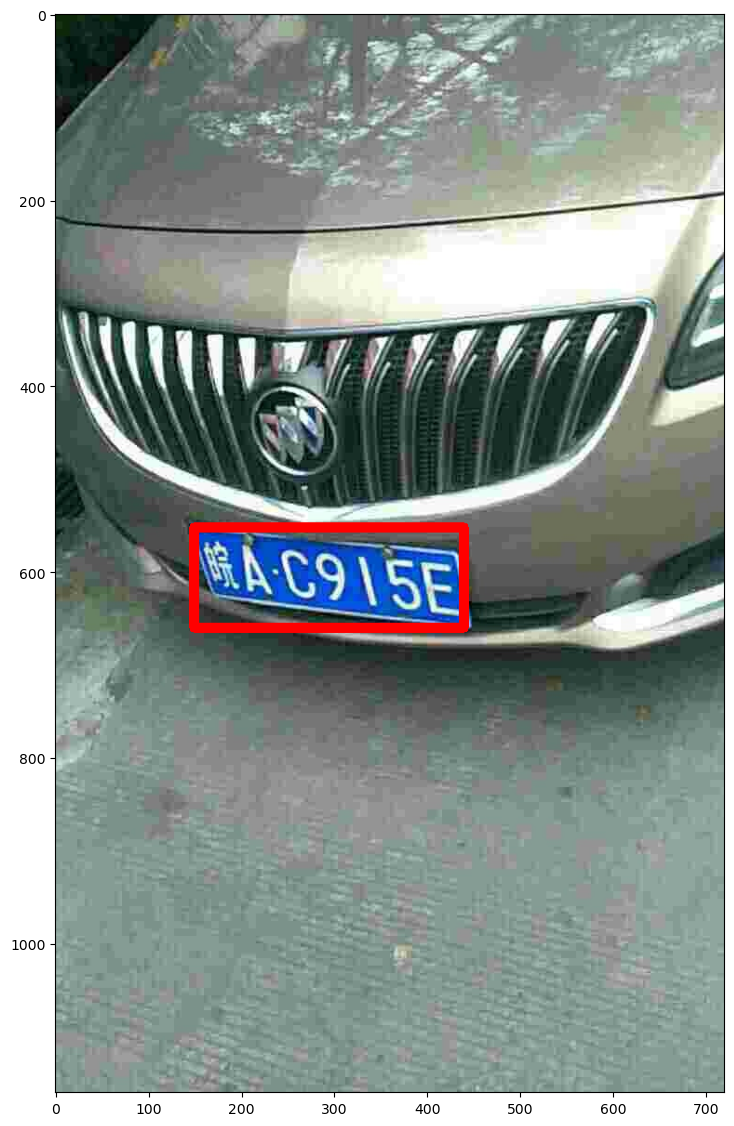

torch.Size([1, 3, 24, 94])


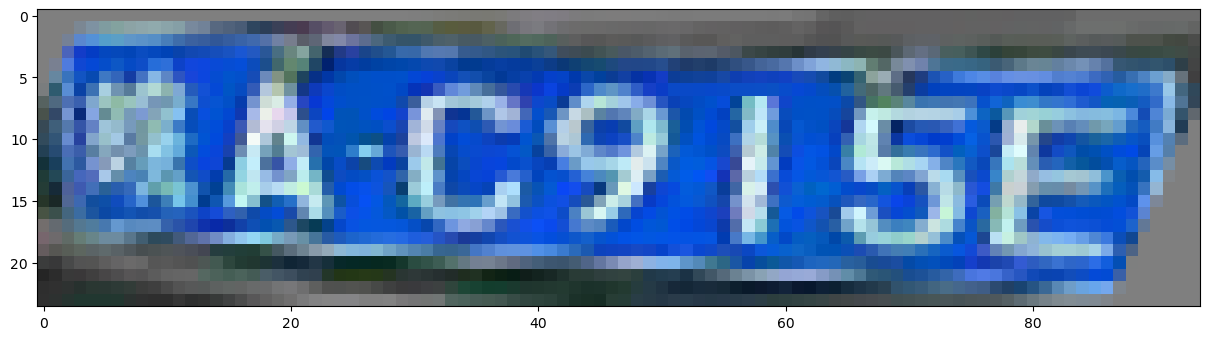

In [33]:
import sys
sys.path.append('./LPRNet')
sys.path.append('./MTCNN')
from LPRNet_Test import *
from MTCNN import *
import numpy as np
import argparse
import torch
import time
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image = cv2.imread('samples/7.jpg')
input = np.copy(image)
bboxes = create_mtcnn_net(input, (50, 15), device, p_model_path='MTCNN/weights/pnet_Weights', o_model_path='MTCNN/weights/onet_Weights')
print(bboxes)

for i in range(bboxes.shape[0]):
    bbox = bboxes[i, :4]
    x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]      
    cv2.rectangle(input, (x1, y1), (x2, y2), (0, 0, 255), 10)
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(input[:,:,::-1])
plt.rcParams['figure.figsize']=(15, 14)
plt.show()
    
def convert_image(inp):
    # convert a Tensor to numpy image
    inp = inp.squeeze(0).cpu()
    inp = inp.detach().numpy().transpose((1,2,0))
    inp = 127.5 + inp/0.0078125
    inp = inp.astype('uint8') 
    return inp

STN = STNet()
STN.to(device)
STN.load_state_dict(torch.load('LPRNet/weights/Final_STN_model.pth', map_location=lambda storage, loc: storage))
STN.eval()

bbox = bboxes[0, :4]
x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]      
w = int(x2 - x1 + 1.0)
h = int(y2 - y1 + 1.0)
img_box = np.zeros((h, w, 3))
img_box = image[y1:y2+1, x1:x2+1, :]
im = cv2.resize(img_box, (94, 24), interpolation=cv2.INTER_CUBIC)
im = (np.transpose(np.float32(im), (2, 0, 1)) - 127.5)*0.0078125
data = torch.from_numpy(im).float().unsqueeze(0).to(device)  # torch.Size([1, 3, 24, 94]) 
transfer = STN(data)
print(transfer.shape)
transformed_img = convert_image(transfer)

plt.imshow(transformed_img[:,:,::-1])
plt.show()

In [ ]:
import torch.nn as nn
import torch

class small_basic_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(small_basic_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
        )
    def forward(self, x):
        return self.block(x)

class LPRNet(nn.Module):
    def __init__(self, class_num, dropout_rate):
        super(LPRNet, self).__init__()
        self.class_num = class_num
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1), # 0
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),  # 2
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
            small_basic_block(ch_in=64, ch_out=128),    # *** 4 ***
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  # 6
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
            small_basic_block(ch_in=64, ch_out=256),   # 8
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 10
            small_basic_block(ch_in=256, ch_out=256),   # *** 11 ***
            nn.BatchNorm2d(num_features=256),   # 12
            nn.ReLU(), #13
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),  # 14
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),  # 16
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),  # 18
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1), # 20
            nn.BatchNorm2d(num_features=class_num),
            nn.ReLU(),  # *** 22 ***
        )
        self.container = nn.Sequential(
            nn.Conv2d(in_channels=256+class_num+128+64, out_channels=self.class_num, kernel_size=(1,1), stride=(1,1)),
            # nn.BatchNorm2d(num_features=self.class_num),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=self.class_num, out_channels=self.lpr_max_len+1, kernel_size=3, stride=2),
            # nn.ReLU(),
        )

    def forward(self, x):
        keep_features = list()
        for i, layer in enumerate(self.backbone.children()):
            x = layer(x)
            if i in [2, 6, 13, 22]: # [2, 4, 8, 11, 22]
                print("intermediate feature map {} shape is: ".format(i), x.shape)
                keep_features.append(x)

        global_context = list()
        for i, f in enumerate(keep_features):
            if i in [0, 1]:
                f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
            if i in [2]:
                f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)
            f_pow = torch.pow(f, 2)
            f_mean = torch.mean(f_pow)
            f = torch.div(f, f_mean)
            print("after globel context {} shape is: ".format(i), f.shape)
            global_context.append(f)

        x = torch.cat(global_context, 1)
        x = self.container(x)
        print("after container shape is: ", x.shape)
        logits = torch.mean(x, dim=2)

        return logits
    
CHARS = ['京', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑',
     '苏', '浙', '皖', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤',
     '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁',
     '新',
     '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
     'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
     'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
     'W', 'X', 'Y', 'Z', 'I', 'O', '-'
     ]

In [ ]:
lprnet = LPRNet(class_num=len(CHARS), dropout_rate=0)
lprnet.to(device)
lprnet.load_state_dict(torch.load('LPRNet/weights/Final_LPRNet_model.pth', map_location=lambda storage, loc: storage))
lprnet.eval()
preds = lprnet(transfer)
print("output shape is: ", preds.shape)

In [ ]:
def decode(preds, CHARS):
    # greedy decode
    pred_labels = list()
    labels = list()
    for i in range(preds.shape[0]):
        pred = preds[i, :, :]
        pred_label = list()
        for j in range(pred.shape[1]):
            pred_label.append(np.argmax(pred[:, j], axis=0))
        no_repeat_blank_label = list()
        pre_c = pred_label[0]
        for c in pred_label: # dropout repeate label and blank label
            if (pre_c == c) or (c == len(CHARS) - 1):
                if c == len(CHARS) - 1:
                    pre_c = c
                continue
            no_repeat_blank_label.append(c)
            pre_c = c
        pred_labels.append(no_repeat_blank_label)
        
    for i, label in enumerate(pred_labels):
        lb = ""
        for i in label:
            lb += CHARS[i]
        labels.append(lb)
    
    return labels, np.array(pred_labels) 

preds = preds.cpu().detach().numpy()  # (1, 68, 18)
labels, pred_labels = decode(preds, CHARS)
print("label is", labels)
print("pred_labels is", pred_labels)

# LPRNet Training

In [ ]:
ctc_loss = nn.CTCLoss(blank=len(CHARS)-1, reduction='mean') # reduction: 'none' | 'mean' | 'sum'

imgs = torch.randn(2,3,24,94)
labels = torch.randint(1,68, (14,), dtype=torch.long)

input_lengths = (18, 18)
target_lengths = (7,7)

transfer = STN(imgs)
logits = lprnet(transfer)  # torch.Size([batch_size, CHARS length, output length ])
log_probs = logits.permute(2, 0, 1) # for ctc loss: length of output x batch x length of chars
log_probs = log_probs.log_softmax(2).requires_grad_()       
loss = ctc_loss(log_probs, labels, input_lengths=input_lengths, target_lengths=target_lengths)

print('loss is: ', loss)

# MTCNN with Realtime Preview

In [16]:
# Neuronal Network Layered Stream with the better fps
import cv2
import IPython
import numpy as np
from typing import Tuple, Union
import math
from PIL import Image
import traceback

import sys
sys.path.append('./LPRNet')
sys.path.append('./MTCNN')
from LPRNet_Test import *
from MTCNN import *
import argparse
import torch
import time
import cv2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

detected_plates = []

# NN Layer License Plate Recognition "OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,0,255))

    # Rotation
    # license_frame = deskew(processed_frame[y1:y2,x1:x2])
    license_frame = processed_frame[y1:y2,x1:x2]
    grayscaled = get_grayscale(np.array(license_frame))
    threshholded = thresholding(grayscaled)
    angle = determine_skew(threshholded)
    print(angle)
    threshholded = rotate(threshholded, angle, (0, 0, 0))

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    max_conf = 0.0
    best_text = ""
    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text])
    cv2.putText(processed_frame, '{} {:.2f}%'.format(best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)

# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(0,255,255))
    vehicle_frame = processed_frame[y1:y2,x1:x2]
    results = plate_model(vehicle_frame, agnostic_nms=True, verbose=False)[0]
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            if name2=="licence": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], "license_plate", confidence2, name, confidence)

# NN Layer Other Objects Detected
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.7,(255,255,0))

# NN Layer Yolov8 Detection
def process_frame(frame):
    processed_frame = frame
    # processed_frame = cv2.flip(processed_frame, 1)    
    # results = model(processed_frame, agnostic_nms=True, verbose=False)[0]
    # for result in results:
    #     detection_count = result.boxes.shape[0]
    #     for i in range(detection_count):
    #         cls = int(result.boxes.cls[i].item())
    #         name = result.names[cls]
    #         confidence = float(result.boxes.conf[i].item())
    #         bounding_box = result.boxes.xyxy[i].cpu().numpy()
    #         x1, y1, x2, y2 = [int(x) for x in bounding_box]
    #         # Ensure x1 < x2 and y1 < y2
    #         x1, x2 = min(x1, x2), max(x1, x2)
    #         y1, y2 = min(y1, y2), max(y1, y2)
    #         if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
    #         else: process_detection(processed_frame, bounding_box, name, confidence)
    
    input = np.copy(frame)
    bboxes = create_mtcnn_net(input, (50, 15), device, p_model_path='MTCNN/weights/pnet_Weights', o_model_path='MTCNN/weights/onet_Weights')

    for i in range(bboxes.shape[0]):
        bbox = bboxes[i, :4]
        x1, y1, x2, y2 = [int(bbox[j]) for j in range(4)]
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)
        process_license(processed_frame, bounding_box)
    return processed_frame

cam = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

if not cam.isOpened(): print("Error: Could not open camera.")
else:
    try:
        while True:
            ret, frame = cam.read()
            if not ret:
                print("Error: Could not capture frame.")
                cam.release()
                break
            processed_frame = process_frame(frame)
            _, processed_frame = cv2.imencode('.jpeg', processed_frame)
            display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        cam.release()
        print("Camera released.")
        
        correct_plates = []
        best_plates = []
        most_repeated_plates = []
        best_repeated_plates = []
        if len(detected_plates)>0:
            repetitions = {}
            count, item = 0, ''  
            for plate in detected_plates:
                if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
                if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: best_plates.append(plate)
                repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
                if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
            if len(repetitions.keys())>0:
                for itm in repetitions.keys():
                    if repetitions[itm]==count:
                        repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                        best_percentages = []
                        for plate in repeated_detected: 
                            if len(best_percentages)==0: best_percentages=plate
                            elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                        most_repeated_plates.append(best_percentages)
            if len(most_repeated_plates)>0:
                for plate in most_repeated_plates:
                    best_repeated = []
                    if len(best_repeated)==0: best_repeated=plate 
                    elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
                best_repeated_plates.append(best_repeated)

        print("\nDetected Plates: \n", np.matrix(detected_plates))
        print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
        print("\nBest Detected Plates: \n", np.matrix(best_plates))
        print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
        print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Camera could not be released.")
        except:
            pass
        traceback.print_exc()

Camera released.

Detected Plates: 
 []

Correctly Detected Plates: 
 []

Best Detected Plates: 
 []

Most Repeated Plates: 
 []

Best Repeated Plate: 
 []


In [ ]:
pip install torch torchvision

In [ ]:
pip install opencv-python

In [12]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn

# Load pre-trained Faster R-CNN
model_faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)
model_faster_rcnn.eval()

# Load pre-trained Mask R-CNN
model_mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
model_mask_rcnn.eval()

C:\Users\Saleh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Saleh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Saleh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
"data/video/sample.MP4"

In [13]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import torchvision.transforms as T
import torch
import time
import traceback
import math

transform = T.Compose([T.ToTensor()])

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife',
    'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

def process_frame(model, frame):
    # Transform the frame to tensor
    frame = transform(frame).unsqueeze(0)
    with torch.no_grad():
        start_time = time.time()  # Start time measurement
        prediction = model(frame)
        end_time = time.time()  # End time measurement
    processing_time = end_time - start_time
    print(f"Processing time: {processing_time:.3f} seconds")  # Output processing time
    return prediction

def process(frame):
    prediction = process_frame(model_faster_rcnn, frame)

    # Visualization: Draw bounding boxes and masks
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label_idx = prediction[0]['labels'][element].cpu().numpy()

        if score > 0.5:  # Filter out detections with low confidence
            label_name = COCO_INSTANCE_CATEGORY_NAMES[label_idx]  # Map the label index to its name
            x1, y1, x2, y2 = map(int, box)
            label_text = f'{label_name} {score:.2f}'  # Use label_name instead of label_idx
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label_text, (x1, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return frame

def handleFrame(frame):
    processed_frame = process(frame)
    
    # Display in Jupyter Notebook
    img = Image.fromarray(processed_frame, 'RGB')
    display(img)
    clear_output(wait=True)
    # _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    # display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    # IPython.display.clear_output(wait=True)
    
def handleRelease():
    cam.release()
    print("Source released.")

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Processing time: 1.533 seconds
Source released.


In [14]:
import cv2
import IPython
import numpy as np
from typing import Tuple, Union
import math
from PIL import Image
import pytesseract
import traceback
import re
import torchvision.transforms as transforms 
import time
from IPython.display import display, clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import easyocr
# reader = easyocr.Reader(['de'])

from ultralytics import YOLO
yolo_model = YOLO('yolov8m.pt')
plate_model = YOLO('best_plate_model.pt')

detected_plates = []

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ" # '0123456789abcdefghijklmnopqrstuvwxyz' # "0123456789ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ"

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# NN Layer License Plate Recognition "OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.9,(255,0,255),2)

    # Rotation
    license_frame = processed_frame[y1:y2,x1:x2]
    
    grayscaled = get_grayscale(license_frame)
    threshholded = thresholding(grayscaled)
    
    max_conf = 0.0
    best_text = ""

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    # NN Layer License Plate Recognition "Dummy OCR"

    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text, "pytesseract"])
    cv2.putText(processed_frame, '{} {:.2f}%'.format("[tesse]: "+best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)
    
# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    
    # Yolov8n Bounding Boxes
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1+25),0,0.8,(0,255,255),2)
    vehicle_frame = processed_frame[y1:y2,x1:x2]
    start_time = time.time()
    results = plate_model(vehicle_frame, agnostic_nms=True, verbose=False)[0]
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Processing time yolov8_license: {processing_time:.3f} seconds")  # Output processing time
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            if name2=="License_Plate": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], name2, confidence2, name, confidence)

# NN Layer Other Objects Detected [Not target classes]
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1+25),0,0.8,(255,255,0),2)
    
# NN Layer Yolov8 Detection
def yolov8n_objects(frame):
    processed_frame = frame
    start_time = time.time()
    results = yolo_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Processing time yolov8m: {processing_time:.3f} seconds")  # Output processing time
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    return processed_frame

def process_frame(frame):
    processed_frame = yolov8n_objects(frame)
    # processed_frame = cv2.flip(processed_frame, 1)
    return processed_frame

def handleFrame(frame):
    processed_frame = process_frame(frame)
    
    # Display in Jupyter Notebook
    img = Image.fromarray(processed_frame, 'RGB')
    display(img)
    clear_output(wait=True)
    # _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    # display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    # IPython.display.clear_output(wait=True)
    
def handleRelease():
    cam.release()
    print("Source released.")
    correct_plates = []
    better_plates = []
    best_plate = []
    most_repeated_plates = []
    best_repeated_plates = []
    highest_score = 0.0
    if len(detected_plates)>0:
        repetitions = {}
        count, item = 0, ''  
        for plate in detected_plates:
            if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
            if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: better_plates.append(plate)
            if plate[0] + plate[2] + plate[4] > highest_score:
                highest_score = plate[0] + plate[2] + plate[4]
                best_plate = plate
            repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
            if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
        if len(repetitions.keys())>0:
            for itm in repetitions.keys():
                if repetitions[itm]==count:
                    repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                    best_percentages = []
                    for plate in repeated_detected: 
                        if len(best_percentages)==0: best_percentages=plate
                        elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                    most_repeated_plates.append(best_percentages)
        if len(most_repeated_plates)>0:
            for plate in most_repeated_plates:
                best_repeated = []
                if len(best_repeated)==0: best_repeated=plate 
                elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
            best_repeated_plates.append(best_repeated)
    print("\nDetected Plates: \n", np.matrix(detected_plates))
    print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
    print("\nBetter Detected Plates: \n", np.matrix(better_plates))
    print("\nBest Detected Plate: \n", np.matrix(best_plate))
    print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
    print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Source released.

Detected Plates: 
 [['65.81149101257324' 'BUS' '79.35512661933899' 'LICENSE_PLATE' '10.537712' 'EE' 'pytesseract']
 ['62.92336583137512' 'TRUCK' '80.85688352584839' 'LICENSE_PLATE' '24.683296' 'SS' 'pytesseract']
 ['82.50477910041809' 'BUS' '81.52228593826294' 'LICENSE_PLATE' '13.037155' 'NN' 'pytesseract']]

Correctly Detected Plates: 
 []

Better Detected Plates: 
 []

Best Detected Plate: 
 [['82.50477910041809' 'BUS' '81.52228593826294' 'LICENSE_PLATE' '13.037155' 'NN' 'pytesseract']]

Most Repeated Plates: 
 [['65.81149101257324' 'BUS' '79.35512661933899' 'LICENSE_PLATE' '10.537712' 'EE' 'pytesseract']
 ['62.92336583137512' 'TRUCK' '80.85688352584839' 'LICENSE_PLATE' '24.683296' 'SS' 'pytesseract']
 ['82.50477910041809' 'BUS' '81.52228593826294' 'LICENSE_PLATE' '13.037155' 'NN' 'pytesseract']]

Best Repeated Plate: 
 [['82.50477910041809' 'BUS' '81.52228593826294' 'LICENSE_PLATE' '13.037155' 'NN' 'pytesseract']]


In [1]:
import cv2
import IPython
import numpy as np
from typing import Tuple, Union
import math
from PIL import Image
import pytesseract
import traceback
import re
import torchvision.transforms as transforms 
import time
from IPython.display import display, clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# import easyocr
# reader = easyocr.Reader(['de'])

from ultralytics import YOLO
yolo_model = YOLO('yolov8n.pt')
plate_model = YOLO('best_plate_model.pt')

detected_plates = []

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

target_classes = ["truck", "bus", "car"]

characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ" # '0123456789abcdefghijklmnopqrstuvwxyz' # "0123456789ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ"

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# NN Layer License Plate Recognition "OCR"
def process_license(processed_frame, bounding_box, name, confidence, parentName, parentConfidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,0,255),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1-15),0,0.9,(255,0,255),2)

    # Rotation
    license_frame = processed_frame[y1:y2,x1:x2]
    
    grayscaled = get_grayscale(license_frame)
    threshholded = thresholding(grayscaled)
    
    max_conf = 0.0
    best_text = ""

    results = pytesseract.image_to_data(threshholded, config='--psm 6 --oem 3 -c tessedit_char_whitelist=ÄÜÖABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    # NN Layer License Plate Recognition "Dummy OCR"

    parsedLines = results.split('\n')
    best_depth = len(parsedLines)-2
    for line in parsedLines:
        params = line.split()
        if len(params)==12 and float(params[10].replace('conf','0.0'))>max_conf:
            max_conf = float(params[10])
            best_text = params[11]
            if max_conf>0.0 and len(best_text)>0: 
                detected_plates.append([parentConfidence*100, parentName.upper(), confidence*100, name.upper(), max_conf, best_text, "pytesseract"])
    cv2.putText(processed_frame, '{} {:.2f}%'.format("[tesse]: "+best_text, max_conf),(x1+10,y2+25),0,0.9,(0,0,255),3)
    
# NN Layer Vehicle Found -> License Detection
def process_vehicle(processed_frame, bounding_box, name, confidence):
    
    # Yolov8n Bounding Boxes
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(0,255,255),2)
    
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1+25),0,0.8,(0,255,255),2)
    vehicle_frame = processed_frame[y1:y2,x1:x2]
    start_time = time.time()
    results = plate_model(vehicle_frame, agnostic_nms=True, verbose=False)[0]
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Processing time yolov8_license: {processing_time:.3f} seconds")  # Output processing time
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name2 = result.names[cls]
            confidence2 = float(result.boxes.conf[i].item())
            bounding_box2 = result.boxes.xyxy[i].cpu().numpy()
            a1, b1, a2, b2 = [int(x) for x in bounding_box2]
            # Ensure a1 < a2 and b1 < b2
            a1, a2 = min(a1, a2), max(a1, a2)
            b1, b2 = min(b1, b2), max(b1, b2)
            if name2=="License_Plate": process_license(processed_frame, [x1+a1, y1+b1, x1+a2, y1+b2], name2, confidence2, name, confidence)

# NN Layer Other Objects Detected [Not target classes]
def process_detection(processed_frame, bounding_box, name, confidence):
    x1, y1, x2, y2 = [int(x) for x in bounding_box]
    cv2.rectangle(processed_frame,(x1,y1),(x2,y2),(255,255,0),2)
    cv2.putText(processed_frame, '{} {:.2f}%'.format(name.upper(), confidence*100),(x1+10,y1+25),0,0.8,(255,255,0),2)
    
# NN Layer Yolov8 Detection
def yolov8n_objects(frame):
    processed_frame = frame
    start_time = time.time()
    results = yolo_model(processed_frame, agnostic_nms=True, verbose=False)[0]
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Processing time yolov8n: {processing_time:.3f} seconds")  # Output processing time
    for result in results:
        detection_count = result.boxes.shape[0]
        for i in range(detection_count):
            cls = int(result.boxes.cls[i].item())
            name = result.names[cls]
            confidence = float(result.boxes.conf[i].item())
            bounding_box = result.boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = [int(x) for x in bounding_box]
            # Ensure x1 < x2 and y1 < y2
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            if name in target_classes: process_vehicle(processed_frame, bounding_box, name, confidence)
            else: process_detection(processed_frame, bounding_box, name, confidence)
    return processed_frame

def process_frame(frame):
    processed_frame = yolov8n_objects(frame)
    # processed_frame = cv2.flip(processed_frame, 1)
    return processed_frame

def handleFrame(frame):
    processed_frame = process_frame(frame)
    
    # Display in Jupyter Notebook
    img = Image.fromarray(processed_frame, 'RGB')
    display(img)
    clear_output(wait=True)
    # _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    # display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    # IPython.display.clear_output(wait=True)
    
def handleRelease():
    cam.release()
    print("Source released.")
    correct_plates = []
    better_plates = []
    best_plate = []
    most_repeated_plates = []
    best_repeated_plates = []
    highest_score = 0.0
    if len(detected_plates)>0:
        repetitions = {}
        count, item = 0, ''  
        for plate in detected_plates:
            if plate[0]>50.0 and plate[2]>50.0 and plate[4]>50.0: correct_plates.append(plate)
            if plate[0]>70.0 and plate[2]>70.0 and plate[4]>70.0: better_plates.append(plate)
            if plate[0] + plate[2] + plate[4] > highest_score:
                highest_score = plate[0] + plate[2] + plate[4]
                best_plate = plate
            repetitions[plate[5]] = repetitions.get(plate[5], 0) + 1
            if repetitions[plate[5]]>count: count, item = repetitions[plate[5]], plate[5]
        if len(repetitions.keys())>0:
            for itm in repetitions.keys():
                if repetitions[itm]==count:
                    repeated_detected = [plate for plate in detected_plates if plate[5]==itm]
                    best_percentages = []
                    for plate in repeated_detected: 
                        if len(best_percentages)==0: best_percentages=plate
                        elif (plate[0] + plate[2] + plate[4])/3.0>(best_percentages[0] + best_percentages[2] + best_percentages[4])/3.0: best_percentages=plate
                    most_repeated_plates.append(best_percentages)
        if len(most_repeated_plates)>0:
            for plate in most_repeated_plates:
                best_repeated = []
                if len(best_repeated)==0: best_repeated=plate 
                elif (plate[0] + plate[2] + plate[4])/3.0>(best_repeated[0] + best_repeated[2] + best_repeated[4])/3.0: best_repeated=plate
            best_repeated_plates.append(best_repeated)
    print("\nDetected Plates: \n", np.matrix(detected_plates))
    print("\nCorrectly Detected Plates: \n", np.matrix(correct_plates))
    print("\nBetter Detected Plates: \n", np.matrix(better_plates))
    print("\nBest Detected Plate: \n", np.matrix(best_plate))
    print("\nMost Repeated Plates: \n", np.matrix(most_repeated_plates))
    print("\nBest Repeated Plate: \n", np.matrix(best_repeated_plates))

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()


KeyboardInterrupt



In [15]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import time  # Import time module to measure processing time
import traceback
import math

# Load pre-trained model and setup
net = cv2.dnn.readNetFromCaffe('MobileNetSSD_deploy.prototxt', 'MobileNetSSD_deploy.caffemodel')
video = cv2.VideoCapture("data/video/sample.MP4")  # Use 0 for web camera

# Define the list of class labels MobileNet SSD was trained to detect
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]

def process(frame):
    start_time = time.time()  # Start time measurement

    # Convert the frame to a blob and pass the blob through the network
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()

    end_time = time.time()  # End time measurement
    processing_time = end_time - start_time  # Calculate processing time
    print(f"Processing time: {processing_time:.3f} seconds")  # Print processing time

    # Loop over the detections
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # Filter out weak detections
        if confidence > 0.2:
            idx = int(detections[0, 0, i, 1])
            label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
            print(label)  # Print detected objects and confidence

            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")

            # Draw the prediction on the frame
            cv2.rectangle(frame, (startX, startY), (endX, endY), (23, 230, 210), 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (23, 230, 210), 2)

    return frame

def handleFrame(frame):
    processed_frame = process(frame)
    
    # Display in Jupyter Notebook
    img = Image.fromarray(processed_frame, 'RGB')
    display(img)
    clear_output(wait=True)
    # _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    # display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    # IPython.display.clear_output(wait=True)
    
def handleRelease():
    cam.release()
    print("Source released.")

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Source released.


In [40]:
from IPython.display import display, clear_output
import numpy as np
from PIL import Image

# Initialize video capture
video = cv2.VideoCapture(0)

try:
    while True:
        # Capture frame-by-frame
        ret, frame = video.read()
        if not ret:
            break

        # Prepare the frame for detection
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)
        
        # Pass the blob through the network and obtain the detections
        net.setInput(blob)
        detections = net.forward()

        # Loop over the detections
        for i in np.arange(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            
            # Filter out weak detections
            if confidence > 0.2:
                idx = int(detections[0, 0, i, 1])
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                
                label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
                cv2.rectangle(frame, (startX, startY), (endX, endY), (23, 230, 210), 2)
                y = startY - 15 if startY - 15 > 15 else startY + 15
                cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Convert the frame for display
        display_image = Image.fromarray(frame)
        display(display_image)
        clear_output(wait=True)

finally:
    video.release()

In [16]:
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import ssd300_vgg16
from PIL import Image
from IPython.display import display, clear_output
import time
import traceback
import math

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife',
    'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

# Load the pre-trained SSD model
model = ssd300_vgg16(pretrained=True)
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize video capture
video = cv2.VideoCapture("data/video/sample.MP4")

# Transformation for the input image
transform = transforms.Compose([
    #transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

def process(frame):
    start_time = time.time()

    # Convert frame to RGB and PIL Image, then apply transformation
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    image = transform(pil_image).unsqueeze(0).to(device)

    # Object detection
    with torch.no_grad():
        predictions = model(image)

    # Processing time
    processing_time = time.time() - start_time
    print(f"Processing time: {processing_time:.3f} seconds")

    # Visualization
    scores = predictions[0]['scores']
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    confidence_threshold = 0.5

    for score, box, label in zip(scores, boxes, labels):
        if score > confidence_threshold:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label_text = f'{COCO_INSTANCE_CATEGORY_NAMES[label.item()]} ({score:.2f})'
            cv2.putText(frame, label_text, (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return frame

def handleFrame(frame):
    processed_frame = process(frame)
    
    # Display in Jupyter Notebook
    img = Image.fromarray(processed_frame, 'RGB')
    display(img)
    clear_output(wait=True)
    # _, processed_frame = cv2.imencode('.jpeg', processed_frame)
    # display_handle.update(IPython.display.Image(data=processed_frame.tobytes()))
    # IPython.display.clear_output(wait=True)
    
def handleRelease():
    cam.release()
    print("Source released.")

inputType="video"
# cam = cv2.VideoCapture(0)
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Source released.


# General Vehicle Detection Comparison

In [34]:
import cv2
import torch
from torchvision.models.detection import *
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from PIL import Image
import IPython
from IPython.display import display, clear_output
import time
import traceback
import math
from ultralytics import YOLO

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputType="video"
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

transform = transforms.Compose([
    #transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

class DetectionResult():
    def __init__(self, model, label, precision, speed, deviceInput=None, sourceInput=None, frame=None, boundingBox=None, details=None):
        self.model = model
        self.label = label
        self.precision = precision.item() if torch.is_tensor(precision) else precision
        self.speed = speed.item() if torch.is_tensor(speed) else speed
        self.device = deviceInput if deviceInput not None else device
        self.source = sourceInput if sourceInput not None else source
        self.frame = frame
        self.boundingBox = boundingBox
        self.details = details

class ModelResults():
    def __init__(self, model, deviceInput, source, detections, 
                 best_precision, average_precision, worst_precision, 
                 best_speed, average_speed, worst_speed, 
                 best_inference_speed, average_inference_speed, worst_inference_speed, 
                 total_detections, total_inferences):
        self.model = model
        self.device = deviceInput if deviceInput not None else device
        self.source = source
        self.detections = detections
        self.best_precision = best_precision
        self.average_precision = average_precision
        self.worst_precision = worst_precision
        self.best_speed = best_speed
        self.average_speed = average_speed
        self.worst_speed = worst_speed
        self.best_inference_speed = best_inference_speed
        self.average_inference_speed = average_inference_speed
        self.worst_inference_speed = worst_inference_speed
        self.total_detections = total_detections
        self.total_inferences = total_inferences

    def show(self):
        print("Model:", self.model, 
              "\nDevice:",self.device,
              "\nSource:",self.source,
              "\nBest Precision:", self.best_precision, 
              "%\nAverage Precision:", self.average_precision, 
              "%\nWorst Precision:", self.worst_precision, 
              "%\nBest Speed:", self.best_speed, 
              "seconds\nAverage Speed:", self.average_speed, 
              "seconds\nWorst Speed:", self.worst_speed, 
              "seconds\nBest Inference Speed:", self.best_inference_speed, 
              "seconds\nAverage Inference Speed:", self.average_inference_speed, 
              "seconds\nWorst Inference Speed:", self.worst_inference_speed, 
              "seconds\nTotal Detections:", self.total_detections, 
              "\nTotal Inferences:", self.total_inferences, 
              "\n\n")

class DetectionModel():
    def __init__(self, concept, backbone, model, weights, reference, color=None, results=None):
        self.concept = concept
        self.backbone = backbone
        self.model = model(weights) if concept=="YOLO" else model(weights=weights.DEFAULT)
        self.weights = weights
        self.reference = reference
        self.color = color
        self.detections = []
        self.results = results

    def addDetection(self, detection):
        self.detections.append(detection)

    def getDetections(self):
        return self.detections

    def clearDetections(self):
        self.detections = []

    def detectionsCount(self):
        return len(self.detections)

    def inferencesCount(self):
        length = 0
        addedFrames = []
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                if self.detections[i].frame not in addedFrames:
                    addedFrames.append(self.detections[i].frame)
        return len(addedFrames)

    def getAveragePrecision(self):
        sum=0.0
        avg=0.0
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                sum+=self.detections[i].precision
            avg = sum/len(self.detections)
        return  avg.item() if torch.is_tensor(avg) else avg

    def getMaxPrecision(self):
        max=0.0
        for i in range(len(self.detections)):
            if max<self.detections[i].precision:
                max=self.detections[i].precision
        return max.item() if torch.is_tensor(max) else max

    def getMinPrecision(self):
        min=9999999.99
        for i in range(len(self.detections)):
            if min>self.detections[i].precision:
                min=self.detections[i].precision
        return 0.0 if min==9999999.99 else min.item() if torch.is_tensor(min) else min

    def getAverageSpeed(self):
        sum=0.0
        avg=0.0
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                sum+=self.detections[i].speed
            avg = sum/len(self.detections)
        return avg

    def getMaxSpeed(self):
        max=0.0
        for i in range(len(self.detections)):
            if max<self.detections[i].speed:
                max=self.detections[i].speed
        return max

    def getMinSpeed(self):
        min=9999999.99
        for i in range(len(self.detections)):
            if min>self.detections[i].speed:
                min=self.detections[i].speed
        return 0.0 if min==9999999.99 else min

    def getAverageInferenceSpeed(self):
        sum=0.0
        avg=0.0
        addedFrames=[]
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                if self.detections[i].frame not in addedFrames:
                    sum+=self.detections[i].speed
                    addedFrames.append(self.detections[i].frame)
            avg = sum/len(addedFrames) if len(addedFrames)>0 else 0.0
        return avg

    def getMaxInferenceSpeed(self):
        max=0.0
        addedFrames=[]
        for i in range(len(self.detections)):
            if max<self.detections[i].speed and self.detections[i].frame not in addedFrames:
                max=self.detections[i].speed
                addedFrames.append(self.detections[i].frame)
        return max

    def getMinInferenceSpeed(self):
        min=9999999.99
        addedFrames=[]
        for i in range(len(self.detections)):
            if min>self.detections[i].speed and self.detections[i].frame not in addedFrames:
                min=self.detections[i].speed
                addedFrames.append(self.detections[i].frame)
        return 0.0 if min==9999999.99 else min

    def filterPrecisionsBelow(self, minPrecision):
        newDetections = []
        for i in range(len(self.detections)):
            if self.detections[i].precision>=minPrecision:
                newDetections.append(self.detections[i])
        self.detections = newDetections

    def hasResults(self):
        return self.results is not None

    def loadResults(self, results):
        self.results = results

    def printResults(self):
        if not self.hasResults():
            sourceInput = self.detections[0].source if len(self.detections)>0 else source
            deviceInput = self.detections[0].device if len(self.detections)>0 else device
            self.loadResults(
                ModelResults(
                    self.reference, deviceInput, sourceInput, self.detections,
                    self.getMaxPrecision(), self.getAveragePrecision(), self.getMinPrecision(), 
                    self.getMinSpeed(), self.getAverageSpeed(), self.getMaxSpeed(), 
                    self.getMinInferenceSpeed(), self.getAverageInferenceSpeed(), self.getMaxInferenceSpeed(), 
                    self.detectionsCount(), self.inferencesCount()
                )
            )

        self.results.show()

target_classes = ["truck", "bus", "car", "train", "bicycle"]

VEHICLE_DETECTION_MODELS = [
    DetectionModel("FCOS", "resnet50_fpn", fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights, "fcos_resnet", (255,0,0)),
    DetectionModel("RetinaNet", "resnet50_fpn", retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights, "retinanet_resnet", (255,255,0)),
    DetectionModel("RetinaNet", "resnet50_fpn_v2", retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights, "retinanet_resnet_v2", (0,234,255)),
    DetectionModel("FasterRCNN", "resnet50_fpn", fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights, "faster_rcnn_resnet", (170,0,255)),
    DetectionModel("FasterRCNN", "resnet50_fpn_v2", fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights, "faster_rcnn_resnet_v2", (255,127,0)),
    DetectionModel("FasterRCNN", "mobilenet_v3_large_fpn", fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights, "faster_rcnn_mobilenet_v3", (191,255,0)),
    DetectionModel("FasterRCNN", "mobilenet_v3_large_320_fpn", fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights, "faster_rcnn_mobilenet_v3_320", (0,149,255)),
    DetectionModel("MaskRCNN", "resnet50_fpn", maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights, "mask_rcnn_resnet", (255,0,170)),
    DetectionModel("MaskRCNN", "resnet50_fpn_v2", maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights, "mask_rcnn_resnet_v2", (255,212,0)),
    DetectionModel("SSD300", "vgg16", ssd300_vgg16, SSD300_VGG16_Weights, "ssd_vgg16", (106,255,0)),
    DetectionModel("SSDLite320", "mobilenet_v3_large", ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights, "ssd_mobilenet_v3", (0,64,255)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5nu.pt', "yolov5nu", (237,185,185)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5su.pt', "yolov5su", (185,215,237)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5mu.pt', "yolov5mu", (231,233,185)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5lu.pt', "yolov5lu", (220,185,237)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5xu.pt', "yolov5xu", (185,237,224)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5n6u.pt', "yolov5n6u", (170,0,255)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5s6u.pt', "yolov5s6u", (255,255,0)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5m6u.pt', "yolov5m6u", (143,106,35)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5l6u.pt', "yolov5l6u", (255,0,0)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5x6u.pt', "yolov5x6u", (0,64,255)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8n.pt', "yolov8n", (0,234,255)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8s.pt', "yolov8s", (115,115,115)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8m.pt', "yolov8m", (204,204,204)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8l.pt', "yolov8l", (255,0,0)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8x.pt', "yolov8x", (255,255,0)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov9c.pt', "yolov9c", (0,234,255)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov9e.pt', "yolov9e", (170,0,255))
]

def process(frame, frameIndex=-1, source=None):
    for i in range(len(VEHICLE_DETECTION_MODELS)):
        currentModel = VEHICLE_DETECTION_MODELS[i]
        processed_frame = frame.copy()
        
        if currentModel.concept=="YOLO":
            start_time = time.time()
            results = currentModel.model(processed_frame, agnostic_nms=True, verbose=False, device=device)[0]
            processing_time = time.time() - start_time
            for result in results:
                detection_count = result.boxes.shape[0]
                for j in range(detection_count):
                    cls = int(result.boxes.cls[j].item())
                    name = result.names[cls]
                    confidence = float(result.boxes.conf[j].item())
                    bounding_box = result.boxes.xyxy[j].cpu().numpy()
                    if name in target_classes:
                        x1, y1, x2, y2 = [int(x) for x in bounding_box]
                        # Ensure x1 < x2 and y1 < y2
                        x1, x2 = min(x1, x2), max(x1, x2)
                        y1, y2 = min(y1, y2), max(y1, y2)
                        label = '{} ({:.2f}%) ({:.3f}s) {}'.format(name.upper(), confidence*100, processing_time, currentModel.reference)
                        print(label)
                        VEHICLE_DETECTION_MODELS[i].addDetection(DetectionResult(currentModel.reference, name, confidence*100, processing_time, device, source, frameIndex, bounding_box, label))
                        cv2.rectangle(processed_frame, (x1, y1), (x2, y2), currentModel.color, 2)
                        cv2.putText(processed_frame, label, (x1+10, y1+25), 0, 0.8, currentModel.color, 2)
        else:
            weights = currentModel.weights.DEFAULT
            model = currentModel.model
            model.eval()

            # Convert frame to RGB and PIL Image, then apply transformation
            frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            image = transform(pil_image).unsqueeze(0).to(device)
        
            # Object detection
            start_time = time.time()
            with torch.no_grad():
                predictions = model(image)
        
            # Processing time
            processing_time = time.time() - start_time
            
            # Visualization
            scores = predictions[0]['scores']
            boxes = predictions[0]['boxes']
            labels = predictions[0]['labels']
            confidence_threshold = 0.5
        
            for score, box, label in zip(scores, boxes, labels):
                # and score > confidence_threshold
                if weights.meta["categories"][label.item()] in target_classes:
                    x1, y1, x2, y2 = map(int, box)
                    label_text = f'{weights.meta["categories"][label.item()].upper()} ({score*100:.2f}%) ({processing_time:.3f}s) {currentModel.reference}'
                    print(label_text)
                    VEHICLE_DETECTION_MODELS[i].addDetection(DetectionResult(currentModel.reference, weights.meta["categories"][label.item()], float(score.item())*100, processing_time, device, source, frameIndex, box, label_text))
                    cv2.rectangle(processed_frame, (x1, y1), (x2, y2), currentModel.color, 2)
                    cv2.putText(processed_frame, label_text, (x1, y1+20), 0, 0.8, currentModel.color, 2)

        img = Image.fromarray(processed_frame, 'RGB')
        display(img)
        clear_output(wait=True)
    return frame

def handleFrame(frame, frameIndex=-1, source=None):
    processed_frame = process(frame,frameIndex,source)

def handleRelease():
    cam.release()
    print("Source released.")

    BestPrecision=None
    BestAvgPrecision=None
    WorstPrecision=None
    BestSpeed=None
    BestAvgSpeed=None
    WorstSpeed=None
    for i in range(len(VEHICLE_DETECTION_MODELS)):
        currentModel = VEHICLE_DETECTION_MODELS[i]
        currentModel.printResults()
        if BestPrecision is None or BestPrecision.getMaxPrecision()<=currentModel.getMaxPrecision():
            BestPrecision = currentModel
        if BestAvgPrecision is None or BestAvgPrecision.getAveragePrecision()<=currentModel.getAveragePrecision():
            BestAvgPrecision = currentModel
        if WorstPrecision is None or WorstPrecision.getMinPrecision()>=currentModel.getMinPrecision():
            WorstPrecision = currentModel
        if BestSpeed is None or BestSpeed.getMinSpeed()>=currentModel.getMinSpeed():
            BestSpeed = currentModel
        if BestAvgSpeed is None or BestAvgSpeed.getAverageSpeed()>=currentModel.getAverageSpeed():
            BestAvgSpeed = currentModel
        if WorstSpeed is None or WorstSpeed.getMaxSpeed()<=currentModel.getMaxSpeed():
            WorstSpeed = currentModel
            
    if BestPrecision is not None: 
        print("Best Precision:")
        BestPrecision.printResults()
    if BestAvgPrecision is not None: 
        print("Best Average Precision:")
        BestAvgPrecision.printResults()
    if WorstPrecision is not None: 
        print("Worst Precision:")
        WorstPrecision.printResults()
    if BestSpeed is not None: 
        print("Best Speed:")
        BestSpeed.printResults()
    if BestAvgSpeed is not None: 
        print("Best Average Speed:")
        BestAvgSpeed.printResults()
    if WorstSpeed is not None: 
        print("Worst Speed:")
        WorstSpeed.printResults()

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame, frameCount, source)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

Source released.
Model: fcos_resnet 
Best Precision: 84.01497006416321 %
Average Precision: 34.31522064877971 %
Worst Precision: 20.016169548034668 %
Best Speed: 1.3147878646850586 seconds
Average Speed: 1.6757691221861963 seconds
Worst Speed: 2.063619613647461 seconds
Best Inference Speed: 1.3147878646850586 seconds
Average Inference Speed: 1.7024165590604146 seconds
Worst Inference Speed: 2.063619613647461 seconds
Total Detections: 809 
Total Inferences: 84 


Model: retinanet_resnet 
Best Precision: 86.20967268943787 %
Average Precision: 13.914700622645844 %
Worst Precision: 5.000218749046326 %
Best Speed: 1.4359545707702637 seconds
Average Speed: 1.8022473817854596 seconds
Worst Speed: 2.2492806911468506 seconds
Best Inference Speed: 1.4359545707702637 seconds
Average Inference Speed: 1.7978160778681438 seconds
Worst Inference Speed: 2.2492806911468506 seconds
Total Detections: 1824 
Total Inferences: 84 


Model: retinanet_resnet_v2 
Best Precision: 96.10866904258728 %
Average Pre

In [ ]:
Source released.
Model: fcos_resnet 
Best Precision: 84.01497006416321 %
Average Precision: 34.31522064877971 %
Worst Precision: 20.016169548034668 %
Best Speed: 1.3147878646850586 seconds
Average Speed: 1.6757691221861963 seconds
Worst Speed: 2.063619613647461 seconds
Best Inference Speed: 1.3147878646850586 seconds
Average Inference Speed: 1.7024165590604146 seconds
Worst Inference Speed: 2.063619613647461 seconds
Total Detections: 809 
Total Inferences: 84 


Model: retinanet_resnet 
Best Precision: 86.20967268943787 %
Average Precision: 13.914700622645844 %
Worst Precision: 5.000218749046326 %
Best Speed: 1.4359545707702637 seconds
Average Speed: 1.8022473817854596 seconds
Worst Speed: 2.2492806911468506 seconds
Best Inference Speed: 1.4359545707702637 seconds
Average Inference Speed: 1.7978160778681438 seconds
Worst Inference Speed: 2.2492806911468506 seconds
Total Detections: 1824 
Total Inferences: 84 


Model: retinanet_resnet_v2 
Best Precision: 96.10866904258728 %
Average Precision: 16.147036431847436 %
Worst Precision: 5.0005074590444565 %
Best Speed: 1.4612510204315186 seconds
Average Speed: 1.8591078235914833 seconds
Worst Speed: 2.364978313446045 seconds
Best Inference Speed: 1.4612510204315186 seconds
Average Inference Speed: 1.8891064609800066 seconds
Worst Inference Speed: 2.364978313446045 seconds
Total Detections: 1520 
Total Inferences: 84 


Model: faster_rcnn_resnet 
Best Precision: 99.24747347831726 %
Average Precision: 35.27663397164389 %
Worst Precision: 5.061345919966698 %
Best Speed: 1.47483229637146 seconds
Average Speed: 1.6666392898013833 seconds
Worst Speed: 1.87638258934021 seconds
Best Inference Speed: 1.47483229637146 seconds
Average Inference Speed: 1.672638592265901 seconds
Worst Inference Speed: 1.87638258934021 seconds
Total Detections: 699 
Total Inferences: 84 


Model: faster_rcnn_resnet_v2 
Best Precision: 99.60418939590454 %
Average Precision: 33.39243041243491 %
Worst Precision: 5.043753981590271 %
Best Speed: 2.1579532623291016 seconds
Average Speed: 2.3665511102476486 seconds
Worst Speed: 2.6729507446289062 seconds
Best Inference Speed: 2.1579532623291016 seconds
Average Inference Speed: 2.3762204902512685 seconds
Worst Inference Speed: 2.6729507446289062 seconds
Total Detections: 811 
Total Inferences: 84 


Model: faster_rcnn_mobilenet_v3 
Best Precision: 99.35287833213806 %
Average Precision: 37.630537044670845 %
Worst Precision: 5.046924203634262 %
Best Speed: 0.32329869270324707 seconds
Average Speed: 0.43964511818355984 seconds
Worst Speed: 0.6118793487548828 seconds
Best Inference Speed: 0.32329869270324707 seconds
Average Inference Speed: 0.43872777053288053 seconds
Worst Inference Speed: 0.6118793487548828 seconds
Total Detections: 360 
Total Inferences: 84 


Model: faster_rcnn_mobilenet_v3_320 
Best Precision: 98.90456199645996 %
Average Precision: 39.035241101324026 %
Worst Precision: 5.015124008059502 %
Best Speed: 0.15319299697875977 seconds
Average Speed: 0.23418851563767792 seconds
Worst Speed: 0.38596081733703613 seconds
Best Inference Speed: 0.15319299697875977 seconds
Average Inference Speed: 0.2331624570347014 seconds
Worst Inference Speed: 0.38596081733703613 seconds
Total Detections: 337 
Total Inferences: 84 


Model: mask_rcnn_resnet 
Best Precision: 98.711097240448 %
Average Precision: 33.507678455415444 %
Worst Precision: 5.009864270687103 %
Best Speed: 1.5584602355957031 seconds
Average Speed: 1.8010743240311764 seconds
Worst Speed: 2.048617124557495 seconds
Best Inference Speed: 1.5584602355957031 seconds
Average Inference Speed: 1.8049743885085696 seconds
Worst Inference Speed: 2.048617124557495 seconds
Total Detections: 683 
Total Inferences: 84 


Model: mask_rcnn_resnet_v2 
Best Precision: 99.41349625587463 %
Average Precision: 37.65366062972049 %
Worst Precision: 5.005624517798424 %
Best Speed: 2.281203269958496 seconds
Average Speed: 2.565716048681869 seconds
Worst Speed: 2.8655378818511963 seconds
Best Inference Speed: 2.281203269958496 seconds
Average Inference Speed: 2.5558127221607028 seconds
Worst Inference Speed: 2.8655378818511963 seconds
Total Detections: 629 
Total Inferences: 84 


Model: ssd_vgg16 
Best Precision: 95.25397419929504 %
Average Precision: 6.4159581760102995 %
Worst Precision: 2.197788655757904 %
Best Speed: 0.23832917213439941 seconds
Average Speed: 0.3788482849748267 seconds
Worst Speed: 0.5898928642272949 seconds
Best Inference Speed: 0.23832917213439941 seconds
Average Inference Speed: 0.390825507186708 seconds
Worst Inference Speed: 0.5898928642272949 seconds
Total Detections: 4726 
Total Inferences: 84 


Model: ssd_mobilenet_v3 
Best Precision: 97.86267876625061 %
Average Precision: 3.639173901591716 %
Worst Precision: 0.7162508554756641 %
Best Speed: 0.10209488868713379 seconds
Average Speed: 0.1220671693685016 seconds
Worst Speed: 0.16486883163452148 seconds
Best Inference Speed: 0.10209488868713379 seconds
Average Inference Speed: 0.123209467955998 seconds
Worst Inference Speed: 0.16486883163452148 seconds
Total Detections: 7116 
Total Inferences: 84 


Model: yolov5nu 
Best Precision: 89.55094814300537 %
Average Precision: 60.619191741043664 %
Worst Precision: 25.00203847885132 %
Best Speed: 0.08482599258422852 seconds
Average Speed: 0.1447036603711686 seconds
Worst Speed: 3.8249993324279785 seconds
Best Inference Speed: 0.08482599258422852 seconds
Average Inference Speed: 0.15523647113018726 seconds
Worst Inference Speed: 3.8249993324279785 seconds
Total Detections: 106 
Total Inferences: 83 


Model: yolov5su 
Best Precision: 94.16013956069946 %
Average Precision: 65.40687045838573 %
Worst Precision: 28.957846760749817 %
Best Speed: 0.11858272552490234 seconds
Average Speed: 0.20037320580812965 seconds
Worst Speed: 3.202934741973877 seconds
Best Inference Speed: 0.11858272552490234 seconds
Average Inference Speed: 0.2074131483123416 seconds
Worst Inference Speed: 3.202934741973877 seconds
Total Detections: 101 
Total Inferences: 84 


Model: yolov5mu 
Best Precision: 95.83572149276733 %
Average Precision: 62.67815518473822 %
Worst Precision: 25.00402331352234 %
Best Speed: 0.2091972827911377 seconds
Average Speed: 0.3180890253611973 seconds
Worst Speed: 3.5376415252685547 seconds
Best Inference Speed: 0.2091972827911377 seconds
Average Inference Speed: 0.3337593646276565 seconds
Worst Inference Speed: 3.5376415252685547 seconds
Total Detections: 126 
Total Inferences: 84 


Model: yolov5lu 
Best Precision: 95.45990824699402 %
Average Precision: 73.07906499854079 %
Worst Precision: 25.045570731163025 %
Best Speed: 0.3530998229980469 seconds
Average Speed: 0.5372842453621529 seconds
Worst Speed: 3.817481756210327 seconds
Best Inference Speed: 0.3530998229980469 seconds
Average Inference Speed: 0.5462017343157813 seconds
Worst Inference Speed: 3.817481756210327 seconds
Total Detections: 111 
Total Inferences: 84 


Model: yolov5xu 
Best Precision: 96.57882452011108 %
Average Precision: 75.16264031762663 %
Worst Precision: 25.6292462348938 %
Best Speed: 0.5162966251373291 seconds
Average Speed: 0.7972573549851127 seconds
Worst Speed: 4.638925552368164 seconds
Best Inference Speed: 0.5162966251373291 seconds
Average Inference Speed: 0.8226594981693086 seconds
Worst Inference Speed: 4.638925552368164 seconds
Total Detections: 115 
Total Inferences: 84 


Model: yolov5n6u 
Best Precision: 89.94278907775879 %
Average Precision: 64.1948022654182 %
Worst Precision: 25.59078335762024 %
Best Speed: 0.17982006072998047 seconds
Average Speed: 0.27164958652697113 seconds
Worst Speed: 3.2517809867858887 seconds
Best Inference Speed: 0.17982006072998047 seconds
Average Inference Speed: 0.27749409562065486 seconds
Worst Inference Speed: 3.2517809867858887 seconds
Total Detections: 95 
Total Inferences: 84 


Model: yolov5s6u 
Best Precision: 93.81153583526611 %
Average Precision: 68.75755653633335 %
Worst Precision: 25.863394141197205 %
Best Speed: 0.3013331890106201 seconds
Average Speed: 0.39206495517637674 seconds
Worst Speed: 0.6164541244506836 seconds
Best Inference Speed: 0.3013331890106201 seconds
Average Inference Speed: 0.39915244550590057 seconds
Worst Inference Speed: 0.6164541244506836 seconds
Total Detections: 123 
Total Inferences: 83 


Model: yolov5m6u 
Best Precision: 96.59476280212402 %
Average Precision: 74.30387755070836 %
Worst Precision: 27.020099759101868 %
Best Speed: 0.662224292755127 seconds
Average Speed: 0.8063682977818261 seconds
Worst Speed: 1.104745626449585 seconds
Best Inference Speed: 0.662224292755127 seconds
Average Inference Speed: 0.8202784463583704 seconds
Worst Inference Speed: 1.104745626449585 seconds
Total Detections: 121 
Total Inferences: 83 


Model: yolov5l6u 
Best Precision: 96.98338508605957 %
Average Precision: 76.82155244718722 %
Worst Precision: 25.58591663837433 %
Best Speed: 1.1083221435546875 seconds
Average Speed: 1.3617152353612387 seconds
Worst Speed: 1.94746732711792 seconds
Best Inference Speed: 1.1083221435546875 seconds
Average Inference Speed: 1.3701340977738543 seconds
Worst Inference Speed: 1.94746732711792 seconds
Total Detections: 123 
Total Inferences: 82 


Model: yolov5x6u 
Best Precision: 96.82453870773315 %
Average Precision: 77.49861474148929 %
Worst Precision: 25.649192929267883 %
Best Speed: 1.6921055316925049 seconds
Average Speed: 2.1854661237448454 seconds
Worst Speed: 7.180513381958008 seconds
Best Inference Speed: 1.6921055316925049 seconds
Average Inference Speed: 2.2230422837393626 seconds
Worst Inference Speed: 7.180513381958008 seconds
Total Detections: 128 
Total Inferences: 84 


Model: yolov8n 
Best Precision: 89.87798690795898 %
Average Precision: 64.94164858201538 %
Worst Precision: 25.362318754196167 %
Best Speed: 0.08196425437927246 seconds
Average Speed: 0.13927612882671933 seconds
Worst Speed: 3.286020517349243 seconds
Best Inference Speed: 0.08196425437927246 seconds
Average Inference Speed: 0.14423098734446935 seconds
Worst Inference Speed: 3.286020517349243 seconds
Total Detections: 99 
Total Inferences: 84 


Model: yolov8s 
Best Precision: 96.51697874069214 %
Average Precision: 69.695577560327 %
Worst Precision: 25.33295452594757 %
Best Speed: 0.11999130249023438 seconds
Average Speed: 0.20084755644839034 seconds
Worst Speed: 3.2653698921203613 seconds
Best Inference Speed: 0.11999130249023438 seconds
Average Inference Speed: 0.2124943421000526 seconds
Worst Inference Speed: 3.2653698921203613 seconds
Total Detections: 117 
Total Inferences: 84 


Model: yolov8m 
Best Precision: 96.09609842300415 %
Average Precision: 75.19671217017218 %
Worst Precision: 25.73632299900055 %
Best Speed: 0.21349716186523438 seconds
Average Speed: 0.3369998231940313 seconds
Worst Speed: 3.898172616958618 seconds
Best Inference Speed: 0.21349716186523438 seconds
Average Inference Speed: 0.3480233351389567 seconds
Worst Inference Speed: 3.898172616958618 seconds
Total Detections: 109 
Total Inferences: 84 


Model: yolov8l 
Best Precision: 96.97030186653137 %
Average Precision: 76.0991909750947 %
Worst Precision: 26.122286915779114 %
Best Speed: 0.37825632095336914 seconds
Average Speed: 0.5933225240793314 seconds
Worst Speed: 4.1653971672058105 seconds
Best Inference Speed: 0.37825632095336914 seconds
Average Inference Speed: 0.6058329428945269 seconds
Worst Inference Speed: 4.1653971672058105 seconds
Total Detections: 111 
Total Inferences: 84 


Model: yolov8x 
Best Precision: 96.95289731025696 %
Average Precision: 82.78851406140761 %
Worst Precision: 26.093509793281555 %
Best Speed: 0.5179610252380371 seconds
Average Speed: 0.7353021036494862 seconds
Worst Speed: 5.12945294380188 seconds
Best Inference Speed: 0.5179610252380371 seconds
Average Inference Speed: 0.7519198656082153 seconds
Worst Inference Speed: 5.12945294380188 seconds
Total Detections: 110 
Total Inferences: 84 


Model: yolov9c 
Best Precision: 95.78874111175537 %
Average Precision: 75.3404206729361 %
Worst Precision: 25.40087103843689 %
Best Speed: 0.3158283233642578 seconds
Average Speed: 0.46963344301496235 seconds
Worst Speed: 3.6877005100250244 seconds
Best Inference Speed: 0.3158283233642578 seconds
Average Inference Speed: 0.4779577851295471 seconds
Worst Inference Speed: 3.6877005100250244 seconds
Total Detections: 112 
Total Inferences: 84 


Model: yolov9e 
Best Precision: 96.19094133377075 %
Average Precision: 76.23227601870894 %
Worst Precision: 25.914165377616882 %
Best Speed: 0.6387596130371094 seconds
Average Speed: 0.857001380994916 seconds
Worst Speed: 4.554773330688477 seconds
Best Inference Speed: 0.6387596130371094 seconds
Average Inference Speed: 0.8848170666467576 seconds
Worst Inference Speed: 4.554773330688477 seconds
Total Detections: 128 
Total Inferences: 84 


Best Precision:
Model: faster_rcnn_resnet_v2 
Best Precision: 99.60418939590454 %
Average Precision: 33.39243041243491 %
Worst Precision: 5.043753981590271 %
Best Speed: 2.1579532623291016 seconds
Average Speed: 2.3665511102476486 seconds
Worst Speed: 2.6729507446289062 seconds
Best Inference Speed: 2.1579532623291016 seconds
Average Inference Speed: 2.3762204902512685 seconds
Worst Inference Speed: 2.6729507446289062 seconds
Total Detections: 811 
Total Inferences: 84 


Best Average Precision:
Model: yolov8x 
Best Precision: 96.95289731025696 %
Average Precision: 82.78851406140761 %
Worst Precision: 26.093509793281555 %
Best Speed: 0.5179610252380371 seconds
Average Speed: 0.7353021036494862 seconds
Worst Speed: 5.12945294380188 seconds
Best Inference Speed: 0.5179610252380371 seconds
Average Inference Speed: 0.7519198656082153 seconds
Worst Inference Speed: 5.12945294380188 seconds
Total Detections: 110 
Total Inferences: 84 


Worst Precision:
Model: ssd_mobilenet_v3 
Best Precision: 97.86267876625061 %
Average Precision: 3.639173901591716 %
Worst Precision: 0.7162508554756641 %
Best Speed: 0.10209488868713379 seconds
Average Speed: 0.1220671693685016 seconds
Worst Speed: 0.16486883163452148 seconds
Best Inference Speed: 0.10209488868713379 seconds
Average Inference Speed: 0.123209467955998 seconds
Worst Inference Speed: 0.16486883163452148 seconds
Total Detections: 7116 
Total Inferences: 84 


Best Speed:
Model: yolov8n 
Best Precision: 89.87798690795898 %
Average Precision: 64.94164858201538 %
Worst Precision: 25.362318754196167 %
Best Speed: 0.08196425437927246 seconds
Average Speed: 0.13927612882671933 seconds
Worst Speed: 3.286020517349243 seconds
Best Inference Speed: 0.08196425437927246 seconds
Average Inference Speed: 0.14423098734446935 seconds
Worst Inference Speed: 3.286020517349243 seconds
Total Detections: 99 
Total Inferences: 84 


Best Average Speed:
Model: ssd_mobilenet_v3 
Best Precision: 97.86267876625061 %
Average Precision: 3.639173901591716 %
Worst Precision: 0.7162508554756641 %
Best Speed: 0.10209488868713379 seconds
Average Speed: 0.1220671693685016 seconds
Worst Speed: 0.16486883163452148 seconds
Best Inference Speed: 0.10209488868713379 seconds
Average Inference Speed: 0.123209467955998 seconds
Worst Inference Speed: 0.16486883163452148 seconds
Total Detections: 7116 
Total Inferences: 84 


Worst Speed:
Model: yolov5x6u 
Best Precision: 96.82453870773315 %
Average Precision: 77.49861474148929 %
Worst Precision: 25.649192929267883 %
Best Speed: 1.6921055316925049 seconds
Average Speed: 2.1854661237448454 seconds
Worst Speed: 7.180513381958008 seconds
Best Inference Speed: 1.6921055316925049 seconds
Average Inference Speed: 2.2230422837393626 seconds
Worst Inference Speed: 7.180513381958008 seconds
Total Detections: 128 
Total Inferences: 84 


In [ ]:
import cv2
import torch
from torchvision.models.detection import *
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from PIL import Image
import IPython
from IPython.display import display, clear_output
import time
import traceback
import math
from ultralytics import YOLO

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    #transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

class DetectionModel():
    def __init__(self, concept, backbone, model, weights, reference, color=None):
        self.concept = concept
        self.backbone = backbone
        self.model = model(weights) if concept=="YOLO" else model(weights=weights.DEFAULT)
        self.weights = weights
        self.reference = reference
        self.color = color
        self.detections = []

    def addDetection(self, detection):
        self.detections.append(detection)

    def getDetections(self):
        return self.detections

    def clearDetections(self):
        self.detections = []

    def detectionsCount(self):
        return len(self.detections)

    def inferencesCount(self):
        length = 0
        addedFrames = []
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                if self.detections[i].frame not in addedFrames:
                    addedFrames.append(self.detections[i].frame)
        return len(addedFrames)

    def getAveragePrecision(self):
        sum=0.0
        avg=0.0
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                sum+=self.detections[i].precision
            avg = sum/len(self.detections)
        return  avg.item() if torch.is_tensor(avg) else avg

    def getMaxPrecision(self):
        max=0.0
        for i in range(len(self.detections)):
            if max<self.detections[i].precision:
                max=self.detections[i].precision
        return max.item() if torch.is_tensor(max) else max

    def getMinPrecision(self):
        min=9999999.99
        for i in range(len(self.detections)):
            if min>self.detections[i].precision:
                min=self.detections[i].precision
        return 0.0 if min==9999999.99 else min.item() if torch.is_tensor(min) else min

    def getAverageSpeed(self):
        sum=0.0
        avg=0.0
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                sum+=self.detections[i].speed
            avg = sum/len(self.detections)
        return avg

    def getMaxSpeed(self):
        max=0.0
        for i in range(len(self.detections)):
            if max<self.detections[i].speed:
                max=self.detections[i].speed
        return max

    def getMinSpeed(self):
        min=9999999.99
        for i in range(len(self.detections)):
            if min>self.detections[i].speed:
                min=self.detections[i].speed
        return 0.0 if min==9999999.99 else min

    def getAverageInferenceSpeed(self):
        sum=0.0
        avg=0.0
        addedFrames=[]
        if len(self.detections)>0:
            for i in range(len(self.detections)):
                if self.detections[i].frame not in addedFrames:
                    sum+=self.detections[i].speed
                    addedFrames.append(self.detections[i].frame)
            avg = sum/len(addedFrames) if len(addedFrames)>0 else 0.0
        return avg

    def getMaxInferenceSpeed(self):
        max=0.0
        addedFrames=[]
        for i in range(len(self.detections)):
            if max<self.detections[i].speed and self.detections[i].frame not in addedFrames:
                max=self.detections[i].speed
                addedFrames.append(self.detections[i].frame)
        return max

    def getMinInferenceSpeed(self):
        min=9999999.99
        addedFrames=[]
        for i in range(len(self.detections)):
            if min>self.detections[i].speed and self.detections[i].frame not in addedFrames:
                min=self.detections[i].speed
                addedFrames.append(self.detections[i].frame)
        return 0.0 if min==9999999.99 else min

    def filterPrecisionsBelow(self, minPrecision):
        newDetections = []
        for i in range(len(self.detections)):
            if self.detections[i].precision>=minPrecision:
                newDetections.append(self.detections[i])
        self.detections = newDetections

    def printResults(self):
        print("Model:", self.reference, 
              "\nBest Precision:", self.getMaxPrecision(), 
              "%\nAverage Precision:", self.getAveragePrecision(), 
              "%\nWorst Precision:", self.getMinPrecision(), 
              "%\nBest Speed:", self.getMinSpeed(), 
              "seconds\nAverage Speed:", self.getAverageSpeed(), 
              "seconds\nWorst Speed:", self.getMaxSpeed(), 
              "seconds\nBest Inference Speed:", self.getMinInferenceSpeed(), 
              "seconds\nAverage Inference Speed:", self.getAverageInferenceSpeed(), 
              "seconds\nWorst Inference Speed:", self.getMaxInferenceSpeed(), 
              "seconds\nTotal Detections:", self.detectionsCount(), 
              "\nTotal Inferences:", self.inferencesCount(), 
              "\n\n")

class DetectionResult():
    def __init__(self, model, label, precision, speed, device=None, source=None, frame=None, boundingBox=None, details=None):
        self.model = model
        self.label = label
        self.precision = precision.item() if torch.is_tensor(precision) else precision
        self.speed = speed.item() if torch.is_tensor(speed) else speed
        self.device = device
        self.source = source
        self.frame = frame
        self.boundingBox = boundingBox
        self.details = details

target_classes = ["truck", "bus", "car"]


VEHICLE_DETECTION_MODELS = [
    DetectionModel("FCOS", "resnet50_fpn", fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights, "fcos_resnet", (255,0,0)),
    DetectionModel("RetinaNet", "resnet50_fpn", retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights, "retinanet_resnet", (255,255,0)),
    DetectionModel("RetinaNet", "resnet50_fpn_v2", retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights, "retinanet_resnet_v2", (0,234,255)),
    DetectionModel("FasterRCNN", "resnet50_fpn", fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights, "faster_rcnn_resnet", (170,0,255)),
    DetectionModel("FasterRCNN", "resnet50_fpn_v2", fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights, "faster_rcnn_resnet_v2", (255,127,0)),
    DetectionModel("FasterRCNN", "mobilenet_v3_large_fpn", fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights, "faster_rcnn_mobilenet_v3", (191,255,0)),
    DetectionModel("FasterRCNN", "mobilenet_v3_large_320_fpn", fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights, "faster_rcnn_mobilenet_v3_320", (0,149,255)),
    DetectionModel("MaskRCNN", "resnet50_fpn", maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights, "mask_rcnn_resnet", (255,0,170)),
    DetectionModel("MaskRCNN", "resnet50_fpn_v2", maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights, "mask_rcnn_resnet_v2", (255,212,0)),
    DetectionModel("SSD300", "vgg16", ssd300_vgg16, SSD300_VGG16_Weights, "ssd_vgg16", (106,255,0)),
    DetectionModel("SSDLite320", "mobilenet_v3_large", ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights, "ssd_mobilenet_v3", (0,64,255)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5nu.pt', "yolov5nu", (237,185,185)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5su.pt', "yolov5su", (185,215,237)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5mu.pt', "yolov5mu", (231,233,185)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5lu.pt', "yolov5lu", (220,185,237)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5xu.pt', "yolov5xu", (185,237,224)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5n6u.pt', "yolov5n6u", (143,35,35)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5s6u.pt', "yolov5s6u", (35,98,143)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5m6u.pt', "yolov5m6u", (143,106,35)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5l6u.pt', "yolov5l6u", (107,35,143)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov5x6u.pt', "yolov5x6u", (79,143,35)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8n.pt', "yolov8n", (0,0,0)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8s.pt', "yolov8s", (115,115,115)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8m.pt', "yolov8m", (204,204,204)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8l.pt', "yolov8l", (255,0,0)), # cycle restarts
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov8x.pt', "yolov8x", (255,255,0)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov9c.pt', "yolov9c", (0,234,255)),
    DetectionModel("YOLO", "csp_darknet53", YOLO, 'yolov9e.pt', "yolov9e", (170,0,255))
]

def process(frame, frameIndex=-1, source=None):
    for i in range(len(VEHICLE_DETECTION_MODELS)):
        currentModel = VEHICLE_DETECTION_MODELS[i]
        processed_frame = frame.copy()
        
        if currentModel.concept=="YOLO":
            start_time = time.time()
            results = currentModel.model(processed_frame, agnostic_nms=True, verbose=False)[0]
            processing_time = time.time() - start_time
            for result in results:
                detection_count = result.boxes.shape[0]
                for j in range(detection_count):
                    cls = int(result.boxes.cls[j].item())
                    name = result.names[cls]
                    confidence = float(result.boxes.conf[j].item())
                    bounding_box = result.boxes.xyxy[j].cpu().numpy()
                    if name in target_classes:
                        x1, y1, x2, y2 = [int(x) for x in bounding_box]
                        # Ensure x1 < x2 and y1 < y2
                        x1, x2 = min(x1, x2), max(x1, x2)
                        y1, y2 = min(y1, y2), max(y1, y2)
                        label = '{} ({:.2f}%) ({:.3f}s) {}'.format(name.upper(), confidence*100, processing_time, currentModel.reference)
                        print(label)
                        VEHICLE_DETECTION_MODELS[i].addDetection(DetectionResult(currentModel.reference, name, confidence*100, processing_time, device, source, frameIndex, bounding_box, label))
                        cv2.rectangle(processed_frame, (x1, y1), (x2, y2), currentModel.color, 2)
                        cv2.putText(processed_frame, label, (x1+10, y1+25), 0, 0.8, currentModel.color, 2)
        else:
            weights = currentModel.weights.DEFAULT
            model = currentModel.model
            model.eval()

            # Convert frame to RGB and PIL Image, then apply transformation
            frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            image = transform(pil_image).unsqueeze(0).to(device)
        
            # Object detection
            start_time = time.time()
            with torch.no_grad():
                predictions = model(image)
        
            # Processing time
            processing_time = time.time() - start_time
            
            # Visualization
            scores = predictions[0]['scores']
            boxes = predictions[0]['boxes']
            labels = predictions[0]['labels']
            confidence_threshold = 0.5
        
            for score, box, label in zip(scores, boxes, labels):
                # and score > confidence_threshold
                if weights.meta["categories"][label.item()] in target_classes:
                    x1, y1, x2, y2 = map(int, box)
                    label_text = f'{weights.meta["categories"][label.item()].upper()} ({score*100:.2f}%) ({processing_time:.3f}s) {currentModel.reference}'
                    print(label_text)
                    VEHICLE_DETECTION_MODELS[i].addDetection(DetectionResult(currentModel.reference, weights.meta["categories"][label.item()], float(score.item())*100, processing_time, device, source, frameIndex, box, label_text))
                    cv2.rectangle(processed_frame, (x1, y1), (x2, y2), currentModel.color, 2)
                    cv2.putText(processed_frame, label_text, (x1, y1+20), 0, 0.8, currentModel.color, 2)

        img = Image.fromarray(processed_frame, 'RGB')
        display(img)
        clear_output(wait=True)
    return frame

def handleFrame(frame, frameIndex=-1, source=None):
    processed_frame = process(frame,frameIndex,source)

def handleRelease():
    cam.release()
    print("Source released.")

    BestPrecision=None
    BestAvgPrecision=None
    WorstPrecision=None
    BestSpeed=None
    BestAvgSpeed=None
    WorstSpeed=None
    for i in range(len(VEHICLE_DETECTION_MODELS)):
        currentModel = VEHICLE_DETECTION_MODELS[i]
        currentModel.printResults()
        if BestPrecision is None or BestPrecision.getMaxPrecision()<=currentModel.getMaxPrecision():
            BestPrecision = currentModel
        if BestAvgPrecision is None or BestAvgPrecision.getAveragePrecision()<=currentModel.getAveragePrecision():
            BestAvgPrecision = currentModel
        if WorstPrecision is None or WorstPrecision.getMinPrecision()>=currentModel.getMinPrecision():
            WorstPrecision = currentModel
        if BestSpeed is None or BestSpeed.getMinSpeed()>=currentModel.getMinSpeed():
            BestSpeed = currentModel
        if BestAvgSpeed is None or BestAvgSpeed.getAverageSpeed()>=currentModel.getAverageSpeed():
            BestAvgSpeed = currentModel
        if WorstSpeed is None or WorstSpeed.getMaxSpeed()<=currentModel.getMaxSpeed():
            WorstSpeed = currentModel
            
    if BestPrecision is not None: 
        print("Best Precision:")
        BestPrecision.printResults()
    if BestAvgPrecision is not None: 
        print("Best Average Precision:")
        BestAvgPrecision.printResults()
    if WorstPrecision is not None: 
        print("Worst Precision:")
        WorstPrecision.printResults()
    if BestSpeed is not None: 
        print("Best Speed:")
        BestSpeed.printResults()
    if BestAvgSpeed is not None: 
        print("Best Average Speed:")
        BestAvgSpeed.printResults()
    if WorstSpeed is not None: 
        print("Worst Speed:")
        WorstSpeed.printResults()

inputType="video"
source = "data/video/sample.MP4" if inputType=="video" else 0
cam = cv2.VideoCapture(source)
display_handle=display(None, display_id=True)
every = 60

start = 0 if source!=0 else -1
end = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) if source!=0 else -1
if source!=0: cam.set(1, start)

frameCount=start
while_safety=0
saved_count=0

if not cam.isOpened(): print("Error: Could not open source.")
else:
    try:
        while True if end<0 else frameCount<end:
            _, frame = cam.read()
            if frame is None:
                if source!=0:
                    if while_safety > 2000: break
                    while_safety += 1
                    continue
                else:
                    print("Error: Could not capture frame.")
                    cam.release()
                    break
                    
            if every>0:
                if (frameCount+1)%math.floor(every) == 0:
                    while_safety = 0
                    handleFrame(frame, frameCount, source)
            else:
                while_safety=0
                handleFrame(frame)
            frameCount += 1
        handleRelease()
    except KeyboardInterrupt:
        handleRelease()
    except:
        print("Unknown error.")
        try:
            cam.release()
            raise TypeError("Error: Source could not be released.")
        except:
            pass
        traceback.print_exc()

In [6]:
from ultralytics import YOLO
model = YOLO('yolov6n.pt')
model.eval()

SSLError: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/ultralytics/assets/releases/tags/v8.2.0 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))